# **[Exercises]** Toy Models of Superposition & Sparse AutoEncoders

Colab: [exercises](https://colab.research.google.com/drive/15S4ISFVMQtfc0FPi29HRaX03dWxL65zx?usp=sharing) | [solutions](https://colab.research.google.com/drive/19Qo9wj5rGLjb6KsB9NkKNJkMiHcQhLqo?usp=sharing)

> *This is a version of the Toy Models of Superposition exercises which has been curated for the use of Neel Nanda's SERI MATS scholars, and others who are interested in SAEs but not necessarily the rest of the ARENA curriculum. An adapted version of this will be included in the upcoming ARENA curriculum (possibly split into two separate sets of exercises).*

Please email me at `cal.s.mcdougall@gmail.com` if there are any issues (or [join our Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-1uvoagohe-JUv9xB7Vr143pdx1UBPrzQ) and message me there!).

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/galaxies.jpeg" width="350">


# Introduction & Setup

Superposition is a crucially important concept for understanding how transformers work. A definition from Neel Nanda's glossary:

> Superposition is when a model represents more than n features in an $n$-dimensional activation space. That is, features still correspond to directions, but **the set of interpretable directions is larger than the number of dimensions**.

Why should we expect something like this to happen? In general, the world has way more features than the model has dimensions of freedom, and so we can't have a one-to-one mapping between features and values in our model. But the model has to represent these features somehow. Hence, it comes up with techniques for cramming multiple features into fewer dimensions (at the cost of adding noise and interference between features).

The exercises here are split into three main sections (described in more detail below). The first three sections introduce Anthropic's toy models of superposition, and show how this model can illustrate important concepts about superposition. The next two sections dive deeper into specific lines of research that grew from the toy model setup. The last two sections introduce **sparse autoencoders**, an exciting line of research which hopes to solve the barriers to interpretability which superposition presents.

## Content & Learning Objectives


Unlike many other topics in this chapter, there's quite a bit of theory which needs to be understood before we start making inferences from the results of our coding experiments. We start by suggesting a few useful papers / videos / blog posts for you to go through, then we'll move into replication of the main results from the "toy models" paper. We'll conclude with a discussion of future directions for superposition research.

A key point to make here is that, perhaps more so than any other section in this chapter, we really don't understand superposition that well at all! It's hard to point to the seminal work in this field because we don't really know what the critical new insights will look like. That being said, we hope this material gives you enough directions to pursue when you're finished!

This notebook is split into 7 chapters. It's easily the longest single set of exercises in this entire chapter (possibly even more than twice as long as any other set if you count all exercises), however we've kept it as one set of exercises so that it's self-contained and doesn't have any prerequisites. For example, we don't want to separate the SAE exercises from the first section (intro to Anthropic's toy models) because we strongly encourage people to at least do the first few exercises in the toy models section & understand the basic ideas behind superposition before trying to tackle SAEs.



### Toy Models of Superposition (sections 1-3)

In these sections, you'll be exposed to Anthropic's toy models of superposition. You'll learn about the key ideas of superposition and why it presents a problem for interpreting neural networks, and you'll experiment with different ways of visualising superposition. You'll also see how properties like sparsity and importance of features affect the degree and nature of superposition.

> ##### Learning objectives
>
> - Understand the concept of superposition, and why models need to do it
> - Understand the difference between superposition and polysemanticity
> - Understand the difference between neuron and bottleneck superposition (or computational and representational superposition)
> - Build & train the toy model from Anthropic's paper, replicate the main results
> - See how superposition varies when you change the following characteristics of the features:
>   - Importance
>   - Sparsity
>   - Correlation



### Toy Models of Superposition: extensions (sections 4-5)

The next two sections take deep dives into some extension topics from the toy models paper: namely the geometry of superposition, and deep double descent. We don't consider these exercises as essential as the previous ones, but they're still very interesting and worth doing if you have time, or just want to dive more deeply into superposition.

> ##### Learning objectives
>
> - Understand the geometric intuitions behind superposition, and how they relate to the more general ideas of superposition in larger models
> - Understand how superposition might relate to double descent, and the idea of memorizing vs generalizing solutions



### Sparse AutoEncoders (section 6-7)

In this last section, you'll learn about sparse autoencoders, and how they might help us resolve problems of superposition. You'll first train an SAE on the toy model setup from earlier sections, then conclude by investigating an SAE trained on a real language model.

> ##### Learning objectives (toy models, extensions: sections 6-7)
>
> - Learn about sparse autoencoders, and how they might be used to disentangle features represented in superposition
> - Train your own SAEs on the toy models from earlier sections, and visualise the feature reconstruction process
> - Interpret SAEs trained on real language models, and see what kinds of features they can find which are dense in the neuron basis

## Setup (don't read, just run!)


In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/eindex.git

    # Code to download the necessary files
    import os, sys
    from pathlib import Path
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/sae-exercises-mats/zip/refs/heads/main
        !unzip /content/main.zip
        for f in Path("sae-exercises-mats-main").iterdir():
            f.rename(f.name)
        os.remove("/content/main.zip")
        os.rmdir("sae-exercises-mats-main")

    # Code to make matplotlib figures work (particularly animations)
    from matplotlib import rc
    rc('animation', html='jshtml')
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")
    %matplotlib qt

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from IPython.display import display, HTML

from plotly.express import imshow, line, histogram
from plotly_utils_toy_models import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)
import tests as tests
import solutions as solutions

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

2025-05-27 15:08:11.803011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 15:08:11.865475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 15:08:11.866049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 15:08:11.956497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 15:08:13.082320: W tensorflow/compiler/tf

## Reading Material

Here are a few recommended resources to help you get started. Each one is labelled with what you should read, at minimum.

Required:

* [200 COP in MI: Exploring Polysemanticity and Superposition](https://www.alignmentforum.org/posts/o6ptPu7arZrqRCxyz/200-cop-in-mi-exploring-polysemanticity-and-superposition)
    * Read the post, up to and including "Tips" (although some parts of it might make more sense after you've read the other things here).
* Neel Nanda's [Dynalist notes on superposition](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2)
    * These aren't long, you should skim through them, and also use them as a reference during these exercises.
* [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html) (Anthropic paper)
    * You should read up to & including the "Summary: A Hierarchy of Feature Properties" section.
    * The first few sections ("Key Results", "Definitions and Motivation", and "Empirical Phenomena" are particularly important).
    * We'll also be going through other parts of this paper as we work through the exercises.

Optional:

* Appendix of [Finding Neurons in a Haystack: Case Studies with Sparse Probing](https://arxiv.org/abs/2305.01610)
    * Despite this paper not *just* being about superposition, it has some of the best-written explanations of superposition concepts.
    * Sections A.6 - A.9 are particularly good.
* Neel Nanda's [video walkthrough of superposition](https://www.youtube.com/watch?v=R3nbXgMnVqQ)
    * This is very long and you don't *have* to watch it, but we weakly recommend it.


## Questions

Here are a set of questions (with some brief answers provided) which you should be able to answer for yourself after reading the above material. Seach for them on Neel's Dynalist notes if you didn't come across them during your reading.

What is a **privileged basis**? Why should we expect neuron activations to be privileged by default? Why *shouldn't* we expect the residual stream to be privileged?

<details>
<summary>Answer</summary>

A privileged basis is one where the standard basis vectors are meaningful, i.e. they represent some human-understandable concepts.

Neuron activations are privileged because of the **nonlinear function that gets applied**. As an example, consider a simple case of 2 neurons (represented as `x` and `y` coordinates), and suppose we want to store two features in this vector space. If we stored them in non-basis directions, then it would be messy to extract each feature individally (we'd get interference between the two).

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/priv-basis.png" width="750">

The residual stream is not privileged because anything that reads from it and writes to it uses a linear map. As a thought experiment, if we changed all the writing matrices (i.e. $W_{out}$ in the MLP layers and $W_O$ in the attention layers) to $W \to W R$, and all the reading matrices (i.e. $W_{in}$ in the MLP layers and $W_Q$, $W_K$, $W_V$ in the attention layers) to $W \to W R^{-1}$ where $R$ is some arbitrary rotation matrix, then the model's computation would be unchanged. Since the matrix $R$ is arbitrary, it can change the basis in any way it wants, so that basis can't be privileged.

To take this back to the analogy for transformers as [people standing in a line](https://www.lesswrong.com/posts/euam65XjigaCJQkcN/an-analogy-for-understanding-transformers), imagine everyone in the line was speaking and thinking in a different language (which had a 1-1 mapping with English, but which you (an outside observer) didn't have a dictionary for). This wouldn't meaningfully change the way the people in the line were sharing and processing information, it would just change the way the information was stored - and without the dictionary (or any additional context), you can't interpret this information.
</details>

What is the difference between **neuron superposition** and **neuron polysemanticity**?

<details>
<summary>Answer</summary>

Polysemanticity happens when one neuron corresponds to multiple features (see [here](https://distill.pub/2020/circuits/zoom-in/#:~:text=lot%20of%20effort.-,Polysemantic%20Neurons,-This%20essay%20may) for more discussion & examples). If we only had polysemanticity, this wouldn't really be a problem for us (there might exist a basis for features s.t. each basis vector corresponds to a single feature).

Superposition is when there are **more features than neurons**. So it implies polysemanticity (because we must have neurons representing more than one feature), but the converse is not true.
</details>


What are the **importance** and **sparsity** of features? Do you expect more or less polysemantic neurons if sparsity is larger?

<details>
<summary>Answer</summary>

**Importance** = how useful is this feature for achieving lower loss?

**Sparsity** = how frequently is it in the input data?

If sparsity is larger, then we expect more polysemantic neurons. This is because a single neuron can afford to represent several different sparse features (usually it'll only be representing one of them at any given time, so there won't be interference).
</details>

How would you define a **feature**?

<details>
<summary>Answer</summary>

There's no single correct answer to this. Many of the definitions are unfortunately circular (e.g. "a feature is a thing which could be represented by a neuron"). A few possible definitions are this one from Neel's [Dynalist notes](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#q=feature):

> A feature is a property of an input to the model, or some subset of that input (eg a token in the prompt given to a language model, or a patch of an image).

or this similar one from Chris Olah's [Distil Circuits Thread](https://distill.pub/2020/circuits/zoom-in/):

> A feature is a a scalar function of the input. In this essay, neural network features are directions, and often simply individual neurons. We claim such features in neural networks are typically meaningful features which can be rigorously studied. A **meaningful feature** is one that genuinely responds to an articulable property of the input, such as the presence of a curve or a floppy ear.
</details>


# (1) TMS: Superposition in a Nonprivileged Basis

## Toy Model - setup

In this section, we'll be examining & running experiments on the toy model studied in [Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html).

You can follow along with the paper from the [Demonstrating Superposition](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating) section onwards; it will approximately follow the order of the sections in this notebook.

This paper presented a very rudimentary model for **bottleneck superposition** - when you try and represent more than $n$ features in a vector space of dimension $n$. The model is as follows:

* We take a 5-dimensional input $x$
* We map it down into 2D space
* We map it back up into 5D space (using the transpose of the first matrix)
* We add a bias and ReLU

$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b)
\end{aligned}
$$

### What's the motivation for this setup?

The input $x$ represents our five features (they're uniformly sampled between 0 and 1).

Each feature can have **importance** and **sparsity**. Recall our earlier definitions:

* **Importance** = how useful is this feature for achieving lower loss?
* **Sparsity** = how frequently is it in the input data?

This is realised in our toy model as follows:

* **Importance** = the coefficient on the weighted mean squared error between the input and output, which we use for training the model
    * In other words, our loss function is $L = \sum_x \sum_i I_i (x_i - x_i^\prime)^2$, where $I_i$ is the importance of feature $i$.
* **Sparsity** = the probability of the corresponding element in $x$ being non-zero
    * In other words, this affects the way our training data is generated (see the method `generate_batch` in the `Module` class below)

The justification for using $W^T W$ is as follows: we can think of $W$ (which is a matrix of shape `(2, 5)`) as a grid of "overlap values" between the features and bottleneck dimensions. The values of the 5x5 matrix $W^T W$ are the dot products between the 2D representations of each pair of features. To make this intuition clearer, imagine each of the columns of $W$ were unit vectors, then $W^T W$ would be a matrix of cosine similarities between the features (with diagonal elements equal to 1, because the similarity of a feature with itself is 1). To see this for yourself:


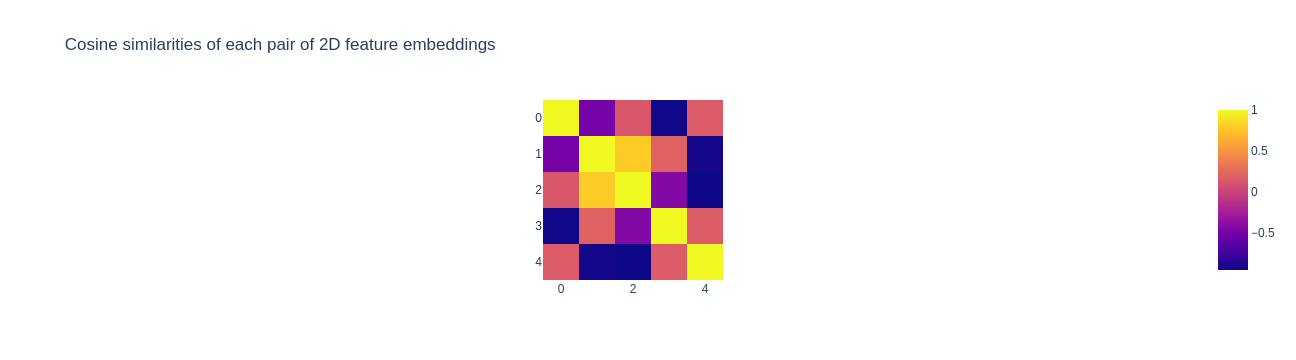

In [8]:
W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600)

To put it another way - if the columns of $W$ were orthogonal, then $W^T W$ would be the identity. This can't actually be the case because $W$ is a 2x5 matrix, but its columns can be "nearly orthgonal" in the sense of having pairwise cosine similarities close to 0.

<details>
<summary>

Question - can you prove that $W^T W$ can't be the identity when $W$ is not a square matrix?
</summary>

Proof #1: the rank of a matrix product $AB$ is upper-bounded by the maximum of the two factors $A$ and $B$. In the case of $W^T W$, both matrices have rank at most 2, so the product has rank at most 2.

Proof #2: for any vector $x$, $W^T W x = W^T (Wx)$ is in the span of the columns of $W^T$, which is vector space with rank 2.

</details>


Another nice thing about using two bottleneck dimensions is that we get to visualise our output! We've got a few helper functions for this purpose.


In [21]:
W_normed.unsqueeze(0).shape

torch.Size([1, 2, 5])

RuntimeError: x must be a sequence

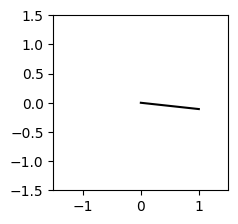

In [23]:
plot_features_in_2d(
    W_normed.unsqueeze(0), # shape [instances=1 d_hidden=2 features=5]
)

Compare this plot to the `imshow` plot above, and make sure you understand what's going on here (and how the two plots relate to each other). A lot of the subsequent exercises run with this idea of a geometric interpretation of the model's features and bottleneck dimensions.

<details>
<summary>Help - I'm confused about how these plots work.</summary>

As mentioned, you can view $W$ as being a set of five 2D vectors, one for each of our five features. The heatmap shows us the cosine similarities between each pair of these vectors, and the second plot shows us these five vectors in 2D space.

For example, run the following code@

```python
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600)

plot_W(W_normed)
```

In the heatmap, we can see two pairs of vectors (the 1st & 2nd, and the 0th & 4th) have very high cosine similarity. This is reflected in the 2D plot, where these features are very close to each other (the 0th feature is the darkest color, the 4th feature is the lightest).

</details>


### Exercise - define your model

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

Below is some code for your model. It should be familiar to you if you've already built simple neural networks earlier in this course.

For now, you just need to fill in the `__init__` and `forward` functions. As the exercises go on, you'll fill in some more of these functions, but for now you can ignore the others.

A few things to note:

* The `Config` class has an `n_instances` class. This is so we can optimize multiple models at once in a single training loop (this'll be useful later on).
    * You should treat this as basically like a batch dimension for your weights: you have multiple weight matrices stacked together, each of which is trained independently & in parallel.
    * All your weight & bias matrices will have an `n_instances` dimension at the start.
    * Each instance will be trained on different data (the data you generate will also have a `n_instances` dimension), although you'll use the same optimizer for all instances.
* The `feature_probability` and `importance` arguments correspond to sparsity and importance of features.
    * The formula is `feature_probability = 1 - sparsity`. We'll often refer to the feature probability rather than the sparsity (since we'll often have $p = 1 - S \approx 0$).
    * The feature probability is used to generate our training data; the importance is used in our loss function (see later for both of these).

You should fill in the `__init__` function, which defines `self.W` and `self.b_final` (see the type annotations). Make sure that `W` is initialized with the [Xavier normal method](https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1init_1a86191a828a085e1c720dbce185d6c307.html). `b_final` can be initialized with zeros.

You should also fill in the `forward` function, to calculate the output (again, the type annotations should be helpful here).

You will fill out the `generate_batch` and `calculate_loss` functions in later exercises.

In [ ]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0


class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        pass


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:

        pass


    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        pass # See below for solutions


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `model.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        '''
        pass # See below for solutions


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


tests.test_model(Model)

<details>
<summary>Solution</summary>


```python
class Model(nn.Module):

    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map (ignoring n_instances) is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        config: Config,
        feature_probability: Optional[Tensor] = None,
        importance: Optional[Tensor] = None,
        device=device
    ):
        super().__init__()
        self.config = config

        if feature_probability is None: feature_probability = t.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None: importance = t.ones(())
        self.importance = importance.to(device)

        # SOLUTION
        self.W = nn.Parameter(t.empty((config.n_instances, config.n_hidden, config.n_features), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(t.zeros((config.n_instances, config.n_features), device=device))



    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        # SOLUTION
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        out = out + self.b_final
        out = F.relu(out)
        return out


    def generate_batch(self, n_batch) -> Float[Tensor, "n_batch instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        # SOLUTION
        feat = t.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
        feat_seeds = t.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
        feat_is_present = feat_seeds <= self.feature_probability
        batch = t.where(
            feat_is_present,
            feat,
            t.zeros((), device=self.W.device),
        )
        return batch
```
</details>


### Exercise - implement the `generate_batch` method

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Next, you should implement the function `generate_batch` above. This should return a tensor of shape `(n_batch, instances, features)`, where:

* The `instances` and `features` values are taken from the model config,
* Each feature is present with probability `self.feature_probability`,
* Each present feature is sampled from a uniform distribution between 0 and 1.

Make sure you understand this function well (we recommend looking at the solutions even after you pass the tests), because we'll be making more complicated versions of this function in the section on correlations.

Note - `self.feature_probability` is guaranteed to broadcast with the `(n_batch, instances, features)` shape. You can read the code in `Model.__init__` which makes sure this is the case.

In [ ]:
def generate_batch(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of data. We'll return to this function later when we apply correlations.
    '''
    pass

In [ ]:
Model.generate_batch = generate_batch

tests.test_generate_batch(Model)

## Training our model


The details of training aren't very conceptually important, so we've given you most of the code to train the model below. We use **learning rate schedulers** to control the learning rate as the model trains - you'll use this later on during the RL chapter.

### Exercise - implement the `calculate_loss` method

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 5-10 minutes on this exercise.
```

You should fill in the `calculate_loss` function below. The loss function **for a single instance** is given by:

$$
L=\frac{1}{BF}\sum_x \sum_i I_i\left(x_i-x_i^{\prime}\right)^2
$$

where:

* $B$ is the batch size,
* $F$ is the number of features,
* $x_i$ are the inputs and $x_i'$ are the model's outputs,
* $I_i$ is the importance of feature $i$,
* $\sum_i$ is a sum over features,
* $\sum_x$ is a sum over the elements in the batch.

For the general case, we sum this formula over all instances.

<details>
<summary>Question - why do you think we take the mean over the feature and batch dimensions, but we sum over the instances dimension?</summary>

We take the mean over batch size because this is standard for loss functions (and means we don't have to use a different learning rate for different batch sizes).

We take the mean over the feature dimension because that's [normal for MSE loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

We sum over the instances dimension because we want to train each instance independently, and at the same rate as we would train a single instance.

</details>

Note - `self.importance` is guaranteed to broadcast with the `(n_batch, instances, features)` shape, just like `self.feature_probability`. You can read the code in `Model.__init__` which makes sure this is the case.

In [ ]:
def calculate_loss(
    self: Model,
    out: Float[Tensor, "batch instances features"],
    batch: Float[Tensor, "batch instances features"],
) -> Float[Tensor, ""]:
    '''
    Calculates the loss for a given batch, using this loss described in the Toy Models paper:

        https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

    Note, `self.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
    '''
    pass

In [ ]:
Model.calculate_loss = calculate_loss

tests.test_calculate_loss(Model)

Now, we'll reproduce a version of the figure from the introduction, although with a slightly different version of the code.

A few notes:

* The `importance` argument is the same for all instances. It takes values between 1 and ~0.66 for each feature (so for every instance, there will be some features which are more important than others).
* The `feature_probability` is the same for all features, but it varies across instances. In other words, we're runnning several different experiments at once, and we can compare the effect of having larger feature sparsity in these experiments.


In [ ]:
cfg = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)

# importance varies within features for each instance
importance = (0.9 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [ ]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model.optimize(steps=10_000)

In [ ]:
plot_features_in_2d(
    model.W.detach(),
    colors = model.importance,
    title = "Superposition: 5 features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

<details>
<summary>Click this dropdown to see what you should be getting from this visualisation.</summary>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/sp1.png" width="1400">

</details>

### Exercise - interpret these diagrams

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 10-20 minutes on this exercise.
```

Remember that for all these diagrams, the darker colors have lower importance and the lighter colors have higher importance. Also, the sparsity of all features is increasing as we move from left to right (at the far left there is no sparsity, at the far right feature probability is 5% for all features, i.e. sparsity of 95%).

<details>
<summary>Hint</summary>

For low sparsity, think about what the model would learn to do if all 5 features were present all the time. What's the best our model could do in this case, and how does that relate to the **importance** values?

For high sparsity, think about what the model would learn to do if there was always exactly one feature present. Does this make interference between features less of a problem?
</details>

<details>
<summary>Answer (intuitive)</summary>

When there is no sparsity, the model can never represent more than 2 features faithfully, so it makes sense for it to only represent the two most important features. It stores them orthogonally in 2D space, and sets the other 3 features to zero. This way, it can reconstruct these two features perfectly, and ignores all the rest.

When there is high sparsity, we get a pentagon structure. Most of the time at most one of these five features will be active, which helps avoid **interference** between features. When we try to recover our initial features by projecting our point in 2D space onto these five directions, most of the time when feature $i$ is present, we can be confident that our projection onto the $i$-th feature direction only captures this feature, rather than being affected by the presence of other features. We omit the mathematical details here.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/download (7).png" width="900">

The key idea here is that two forces are competing in our model: **feature benefit** (representing more thing is good!), and **interference** (representing things non-orthogonally is bad). The higher the sparsity, the more we can reduce the negative impact of interference, and so the trade-off skews towards "represent more features, non-orthogonally".

</details>


We can also generate a batch and visualise its embedding. Most interestingly, you should see that in the plots with high sparsity (to the right), we very rarely have interference between the five features, because most often $\leq 1$ of those features is present, and the model can recover it by projecting along the corresponding feature dimension without losing any information.

In [ ]:
with t.inference_mode():
    batch = model.generate_batch(200)
    hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")

plot_features_in_2d(hidden, title = "Hidden state representation of a random batch of data")

<details>
<summary>Click this dropdown to see what you should be getting from this visualisation.</summary>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/hs1.png" width="1400">

</details>

## Visualizing features across varying sparsity


Now that we've got our pentagon plots and started to get geometric intuition for what's going on, let's scale things up! We're now operating in dimensions too large to visualise, but hopefully our intuitions will carry over.


In [ ]:
n_features = 80
n_hidden = 20

importance = (0.9 ** t.arange(n_features))
importance = einops.rearrange(importance, "features -> () features")

# feature_probability = (20 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = t.tensor([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

cfg = Config(
    n_instances = len(feature_probability.squeeze()),
    n_features = n_features,
    n_hidden = n_hidden,
)

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [ ]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model.optimize(steps=10_000)

Because we can't plot features in 2D anymore, we're going to use a different kind of visualisation:

* The **left hand plots** shows a bar graph of all the features and their corresponding embedding norms $||W_i||$.
    * As we increase sparsity, the model is able to represent more features (i.e. we have more features with embedding norms close to 1).
    * We also color the bars according to whether they're orthogonal to other features (blue) or not (red). So we can see that for low sparsity most features are represented orthogonally (like our left-most plots above) but as we increase sparsity we transition to all features being represented non-orthogonally (like our right-most pentagon plots above).
* The **right hand plots** show us the dot products between all pairs of feature vectors (kinda like the heatmaps we plotted at the start of this section).
    * This is another way of visualising the increasing interference between features as we increase sparsity.
    * Note that all these right hand plots represent **matrices with rank at most `n_hidden=20`**. The first few are approximately submatrices of the identity (because we perfectly reconstruct 20 features and delete the rest), but the later plots start to display inference as we plot more than 20 values (the diagonals of these matrices have more than 20 non-zero elements).

See the section [Basic Results](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-basic-results) for more of an explanation of this graph and what you should interpret from it.

In [ ]:
plot_features_in_Nd(
    model.W,
    height = 600,
    width = 1400,
    title = "ReLU output model: n_features = 80, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles = [f"Feature prob = {i:.3f}" for i in feature_probability[:, 0]],
)

## Bonus - varying feature probability across features

In this section, we've only discussed varying feature probability across instances, and so most of the learned solutions have had uniformity (e.g. a uniform pentagon, or a uniform digon with one feature collapsed). But there's also a large set of non-uniform patterns which can be learned by our models. See the [corresponding section](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-non-uniform) of the Anthropic paper, where they discuss in more detail what happens when a feature's importance is perturbed. Can you reproduce this result? Can you think of a setup which would result in a learned solution where all 5 features are represented, but two features are represented with very high cosine similarity? (You might want to return to this question at the end of the next section!).

In [ ]:
cfg = Config(
    n_instances = 16,
    n_features = 5,
    n_hidden = 2,
)

# now we vary feature probability within features (but same for all instances)
# we make all probs 0.05, except for the first feature which has smaller probability
feature_probability = t.full((cfg.n_instances, cfg.n_features), 0.05)
feature_probability[:, 0] *= t.linspace(0, 1, cfg.n_instances+1)[1:].flip(0)

model = Model(
    cfg = cfg,
    device = device,
    feature_probability = feature_probability,
)
model.optimize(steps=25_000)

plot_features_in_2d(
    model.W,
    colors = model.feature_probability * (1 / model.feature_probability.max()), # to help distinguish colors, we normalize to use the full color range
    title = "Superposition: 5 features represented in 2D space (lighter colors = larger feature probabilities)",
    subplot_titles = [f"1 - S = 0.05 * {i:.2f}" for i in t.linspace(0, 1, cfg.n_instances).flip(0)],
    n_rows = 2,
)

# (2) TMS: Correlated / Anticorrelated Features

One major thing we haven't considered in our experiments is **correlation**. We could guess that superposition is even more common when features are **anticorrelated** (for a similar reason as why it's more common when features are sparse). Most real-world features are anticorrelated (e.g. the feature "this is a sorted Python list" and "this is some text in an edgy teen vampire romance novel" are probably anticorrelated - that is, unless you've been reading some pretty weird fanfics).

In this section, you'll define a new data-generating function for correlated features, and run the same experiments as in the first section.


### Exercise - implement `generate_correlated_batch`

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 20-40 minutes on this exercise.

The exercise itself is not conceptually important, and it is a bit fiddly / delicate, so you should definitely look at the solutions if you get stuck. Understanding the results and why they occur is more important than the implementation!
```

You should now fill in the three methods `generate_correlated_features`, `generate_anticorrelated_features` and `generate_uncorrelated_features` in the `Model` class, which are created to generate correlated / anticorrelated data. A summary of what you will have to do:

* The `generate_correlated_features` function returns a tensor of shape `(batch_size, n_instances, n_features)`, where `n_features = 2 * n_correlated_pairs`, and each feature is correlated with the next feature.
    * In other words, each `output[i, j, 2k]` and `output[i, j, 2k+1]` are correlated: one is non-zero iff the other is non-zero.
    * Hint - create a tensor of random seeds of shape `(batch_size, n_instances, n_correlated_pairs)`, then use `einops.repeat`.
* The `generate_anticorrelated_features` function returns a tensor of shape `(batch_size, n_instances, n_features)`, where `n_features = 2 * n_anticorrelated_pairs`, and each feature is anticorrelated with the next feature.
    * In other words, each `output[i, j, 2k]` and `output[i, j, 2k+1]` are anticorrelated: one is non-zero iff the other is zero.
    * Hint - create a tensor of random seeds of shape `(batch_size, n_instances, n_anticorrelated_pairs)` which determines whether one of the features in a given pair is zero or not, and then for the non-zero features you can use another random seed tensor to determine whether the first or the second feature is non-zero.
    * Note - if `p` is the feature probability, then you should have the probability of any given pair of anticorrelated features being present as `2p` - this is so that any single feature has probability `2p * (1/2) = p` of being present.
* The `generate_uncorrelated_features` function returns a tensor of shape `(batch_size, n_instances, n_uncorrelated)`.
    * This should be exactly the same function as your current version of `generate_batch`.

For these functions you can assume that the `model.feature_probability` is the same for all features (although it might vary across instances). Since `model.feature_probability` automatically gets broadcasted to shape `(n_instances, n_features)` during intialization, you can handle this by just indexing the probability for the first feature with e.g. `[:, 0]` to get a vector of length `n_instances`.

For more details, you can read the [experimental details in Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-correlated-setup), where they describe how they setup correlated and anticorrelated sets.

You should fill in the functions below. Note that we've also given you a new `generate_batch` function, which calculates how many correlated / anticorrelated / uncorrelated features we need, and creates a full batch by concatenating the outputs of these three functions.

In [ ]:
def generate_correlated_features(self: Model, batch_size, n_correlated_pairs) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of correlated features.
    Each output[i, j, 2k] and output[i, j, 2k + 1] are correlated, i.e. one is present iff the other is present.
    '''
    pass


def generate_anticorrelated_features(self: Model, batch_size, n_anticorrelated_pairs) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of anti-correlated features.
    Each output[i, j, 2k] and output[i, j, 2k + 1] are anti-correlated, i.e. one is present iff the other is absent.
    '''
    pass


def generate_uncorrelated_features(self: Model, batch_size, n_uncorrelated) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of uncorrelated features.
    '''
    pass


def generate_batch(self: Model, batch_size):
    '''
    Generates a batch of data, with optional correslated & anticorrelated features.
    '''
    n_uncorrelated = self.cfg.n_features - 2 * self.cfg.n_correlated_pairs - 2 * self.cfg.n_anticorrelated_pairs
    data = []
    if self.cfg.n_correlated_pairs > 0:
        data.append(self.generate_correlated_features(batch_size, self.cfg.n_correlated_pairs))
    if self.cfg.n_anticorrelated_pairs > 0:
        data.append(self.generate_anticorrelated_features(batch_size, self.cfg.n_anticorrelated_pairs))
    if n_uncorrelated > 0:
        data.append(self.generate_uncorrelated_features(batch_size, n_uncorrelated))
    batch = t.cat(data, dim=-1)
    return batch


Model.generate_correlated_features = generate_correlated_features
Model.generate_anticorrelated_features = generate_anticorrelated_features
Model.generate_uncorrelated_features = generate_uncorrelated_features
Model.generate_batch = generate_batch

The code below tests your function, by generating a large number of batches and measuring them statistically.


In [ ]:
cfg = Config(
    n_instances = 30,
    n_features = 4,
    n_hidden = 2,
    n_correlated_pairs = 1,
    n_anticorrelated_pairs = 1,
)

feature_probability = 10 ** -t.linspace(0.5, 1, cfg.n_instances).to(device)

model = Model(
    cfg = cfg,
    device = device,
    feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")
)

# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch = model.generate_batch(batch_size=100_000)
corr0, corr1, anticorr0, anticorr1 = batch.unbind(dim=-1)
corr0_is_active = corr0 != 0
corr1_is_active = corr1 != 0
anticorr0_is_active = anticorr0 != 0
anticorr1_is_active = anticorr1 != 0

assert (corr0_is_active == corr1_is_active).all(), "Correlated features should be active together"
assert (corr0_is_active.float().mean(0) - feature_probability).abs().mean() < 0.002, "Each correlated feature should be active with probability `feature_probability`"

assert (anticorr0_is_active & anticorr1_is_active).int().sum().item() == 0, "Anticorrelated features should never be active together"
assert (anticorr0_is_active.float().mean(0) - feature_probability).abs().mean() < 0.002, "Each anticorrelated feature should be active with probability `feature_probability`"

We can also visualise these features, in the form of a bar chart. You should see the correlated features always co-occurring, and the anticorrelated features never co-occurring.

<details>
<summary>What you should see when you run the code below</summary>


<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/bar-cooccur.png" width="800">

</details>

In [ ]:
# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch = model.generate_batch(batch_size = 1)
correlated_feature_batch, anticorrelated_feature_batch = batch[:, :, :2], batch[:, :, 2:]

# Plot correlated features
plot_correlated_features(correlated_feature_batch, title="Correlated Features: should always co-occur")
plot_correlated_features(anticorrelated_feature_batch, title="Anti-correlated Features: should never co-occur")

Now, let's try training our model & visualising features in 2D, when we have 2 pairs of correlated features (matching the [first figure](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-organization) in the Anthropic paper).

In [ ]:
cfg = Config(
    n_instances = 5,
    n_features = 4,
    n_hidden = 2,
    n_correlated_pairs = 2,
    n_anticorrelated_pairs = 0,
)

# All same importance, very low feature probabilities (ranging from 5% down to 0.25%)
importance = t.ones(cfg.n_features, dtype=t.float, device=device)
importance = einops.rearrange(importance, "features -> () features")
feature_probability = (400 ** -t.linspace(0.5, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model.optimize()

In [ ]:
plot_features_in_2d(
    model.W,
    colors = ["blue"] * 2 + ["limegreen"] * 2, # when colors is a list of strings, it's assumed to be the colors of features
    title = "Correlated feature sets are represented in local orthogonal bases",
    subplot_titles = [f"1 - S = {i:.3f}" for i in model.feature_probability[:, 0]],
)

### Exercise - generate more feature correlation plots

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to ~10 minutes on this exercise.

It should just involve changing the parameters in your code above.
```

You should now plot the second and third figures from the paper. You may not get exactly the same results as the paper, but they should still roughly match (e.g. you should see no antipodal pairs in the code above, but you should see at least some when you test the anticorrelated sets, even if not all of them are antipodal). You can look at the solutions colab to see some examples.

<details>
<summary>Question - for the anticorrelated feature plots, you'l have to increase the feature probability to something like ~10%, or else you won't always form antipodal pairs. Why do you think this is?</summary>

If sparsity is small / feature prob is large, then interference between the two pairs of anticorrelated features is a problem. If two features from different pairs are in the same subspace (because they're antipodal) the model is more likely to keep looking for a better solution.

On the other hand, if sparsity is very large / feature probability is close to zero, then the negative effect of interference is much smaller. So the difference in loss between the solutions where the antipodal pairs are / aren't the same as the anticorrelated pairs is much smaller, and the model is more likely to just settle on whichever solution it finds first.

</details>

# (3) TMS: Superposition in a Privileged Basis


So far, we've explored superposition in a model without a privileged basis. We can rotate the hidden activations arbitrarily and, as long as we rotate all the weights, have the exact same model behavior. That is, for any ReLU output model with weights
$W$, we could take an arbitrary orthogonal matrix $O$ and consider the model $W' = OW$. Since $(OW)^T(OW) = W^T W$, the result would be an identical model!

Models without a privileged basis are elegant, and can be an interesting analogue for certain neural network representations which don't have a privileged basis – word embeddings, or the transformer residual stream. But we'd also (and perhaps primarily) like to understand neural network representations where there are neurons which do impose a privileged basis, such as transformer MLP layers or conv net neurons.

Our goal in this section is to explore the simplest toy model which gives us a privileged basis. There are at least two ways we could do this: we could add an activation function or apply $L_1$ regularization to the hidden layer. We'll focus on adding an activation function, since the representation we are most interested in understanding is hidden layers with neurons, such as the transformer MLP layer.

This gives us the following "ReLU hidden layer" model. It's the simplest one we can use which is still likely to give us a privileged basis; we just take our previous setup and apply ReLU to the hidden layer.

$$
\begin{aligned}
h & =\operatorname{ReLU}(W x) \\
x^{\prime} & =\operatorname{ReLU}\left(W^T h+b\right)
\end{aligned}
$$

### Exercise - implement `NeuronModel`

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to ~10 minutes on this exercise.
```

In this section, you'll replicate the [first set of results](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss:~:text=model%20and%20a-,ReLU%20hidden%20layer%20model,-%3A) in the Anthropic paper on studying superposition in a privileged basis. To do this, you'll need a new `NeuronModel` class. It can inherit most methods from the `Model` class, but you'll need to redefine the `forward` method to include an intermediate ReLU.

In [ ]:
class NeuronModel(Model):
    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Tensor] = None,
        importance: Optional[Tensor] = None,
        device=device
    ):
        super().__init__(cfg, feature_probability, importance, device)

    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        pass


tests.test_neuron_model(NeuronModel)

Once you've passed these tests, you can run the cells below to train the model in the same way as before. We use just one instance, with zero sparsity and uniform importance.

We also visualize the matrix $W$. With the argument `neuron_plot=True`, we make it so that the right-hand visualisation is of $W$ rather than $W^T W$ - we can get away with this now because (unlike before) the individual elements of $W$ *are* meaningful. We're working with a **privileged basis**, and $W$ connects features to basis-aligned neurons.

You might find small deviations from the paper's results. But the most important thing to pay attention to is how **there's a shift from monosemantic to polysemantic neurons as sparsity increases**. Monosemantic neurons do exist in some regimes! Polysemantic neurons exist in others. And they can both exist in the same model! Moreover, while it's not quite clear how to formalize this, it looks a great deal like there's a neuron-level phase change, mirroring the feature phase changes we saw earlier.

In the plots you make below, you should see:

* Total monosemanticity at 5 features & 5 neurons
* With more features than neurons, some of the neurons become polysemantic (but some remain monosemantic)

In [ ]:
n_features = 10
n_hidden = 5

importance = einops.rearrange(0.75 ** t.arange(1, 1+n_features), "feats -> () feats")
feature_probability = einops.rearrange(t.tensor([0.75, 0.35, 0.15, 0.1, 0.06, 0.02, 0.01]), "instances -> instances ()")

cfg = Config(
    n_instances = len(feature_probability.squeeze()),
    n_features = n_features,
    n_hidden = n_hidden,
)

model = NeuronModel(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model.optimize(steps=10_000)

In [ ]:
plot_features_in_Nd(
    model.W,
    height = 600,
    width = 1000,
    title = "Neuron model: n_features = 10, d_hidden = 5, I<sub>i</sub> = 0.75<sup>i</sup>",
    subplot_titles = [f"1 - S = {i:.2f}" for i in feature_probability.squeeze()],
    neuron_plot = True,
)

Try playing around with different settings (sparsity, importance). What kind of results do you get?

You can also try and go further, replicating results later in the paper (e.g. the neuron weight bar plots further on in the paper).

(Note - the argument `show_wtw = False` in the `visualise_Nd_superposition` function means that the right-hand heatmap we see isn't $W^T W$, but just $W$. If you set `show_wtw = False` in the previous section you'd have seen something with no visible pattern because the features had no reason to be monosemantic, but here you should be able to see some monosemantic neurons.)

## Computation in superposition

The example above was interesting, but in some ways it was also limited. The key problem here is that **the model doesn't benefit from the ReLU hidden layer**. Adding a ReLU does encourage the model to have a privileged basis, but since the model is trying to reconstruct the input (i.e. the identity, which is a linear function) it doesn't actually need to use the ReLU, and it will try anything it can to circumvent it - including learning biases which shift all the neurons into a positive regime where they behave linearly. This is a mark against using this toy model to study superposition.

To extend this point: we don't want to study boring linear functions like the identity, we want to study **how models perform (nonlinear) computation in superposition**. The MLP layer in a transformer isn't just a way to represent information faithfully and recover it; it's a way to perform computation on that information. So for this next section, we'll train a model to perform some non-linear computation. Specifically, we'll train our model to **compute the absolute value of inputs $x$**.

Our data $x$ are now sampled from the range $[-1, 1]$ rather than $[0, 1]$ (otherwise calculating the absolute value would be equivalent to reconstructing the input). This is about as simple as a nonlinear function can get, since $abs(x)$ is equivalent to $\operatorname{ReLU}(x) + \operatorname{ReLU}(-x)$. But since it's nonlinear, we can be sure that the model has to use the hidden layer ReLU.

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

You should fill in the `NeuronComputationModel` class below. Specifically, you'll need to fill in the `forward`, `generate_batch` and `calculate_loss` methods. Some guidance:

* The model has a ReLU hidden layer in its forward function (as described above & in the paper). This will require rewriting the `forward` method, but you can keep the same `__init__` method as for the `Model` class (since the weights are the same).
    * We've given you the `__init__` method already. It runs the `__init__` method of the `Model` class, but then deletes the `W` matrix and replaces it with `W1` and `W2`.
* The model's data is different - see the discussion above. Your `generate_batch` function should be rewritten - it will be the same as the first version of this function you wrote (i.e. without correlations) except for one difference: the value is sampled uniformly from the range $[-1, 1]$ rather than $[0, 1]$.
* The model's loss function is different. Rather than computing the (importance-weighted) $L_2$ error between the input $x$ and output $x'$, we're computing the $L_2$ error between $\operatorname{abs}(x)$ and $x'$. This should just require changing one line. The `optimize` function can stay the same, but it will now be optimizing this new loss function.

In [ ]:
class NeuronComputationModel(Model):
    W1: Float[Tensor, "n_instances n_hidden n_features"]
    W2: Float[Tensor, "n_instances n_features n_hidden"]
    b_final: Float[Tensor, "n_instances n_features"]

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Tensor] = None,
        importance: Optional[Tensor] = None,
        device=device
    ):
        super().__init__(cfg, feature_probability, importance, device)

        del self.W
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_features, cfg.n_hidden))))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:

        pass


    def generate_batch(self, batch_size) -> Tensor:

        pass


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:

        pass


tests.test_neuron_computation_model(NeuronComputationModel)

Once you've passed these two tests, you can run the code below to make the same visualisation as above.

You should see similar patterns: with very low sparsity most/all neurons are monosemantic, but more polysemantic neurons appear as sparsity increases (until all neurons are polysemantic). Another interesting observation: in the monosemantic (or mostly monosemantic) cases, for any given feature there will be some neurons which have positive exposures to that feature and others with negative exposure. This is because some neurons are representing the value $\operatorname{ReLU}(x_i)$ and others are representing the value of $\operatorname{ReLU}(-x_i)$ (as discussed above, we require both of these to compute the absolute value).

In [ ]:
n_features = 100
n_hidden = 40

importance = einops.rearrange(0.8 ** t.arange(1, 1+n_features), "feats -> () feats")
feature_probability = einops.rearrange(t.tensor([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]), "instances -> instances ()")

cfg = Config(
    n_instances = len(feature_probability.squeeze()),
    n_features = n_features,
    n_hidden = n_hidden,
)

model = NeuronComputationModel(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model.optimize(steps=10_000)

In [ ]:
plot_features_in_Nd(
    model.W1,
    height = 800,
    width = 1600,
    title = f"Neuron computation model: n_features = {n_features}, d_hidden = {n_hidden}, I<sub>i</sub> = 0.75<sup>i</sup>",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
    neuron_plot = True,
)

To further confirm that this is happening, we can color the values in the bar chart discretely by feature, rather than continuously by the polysemanticity of that feature. We'll use a feature probability of 50% for this visualisation, which is high enough to make sure each neuron is monosemantic. You should find that the input weights $W_1$ form pairs of antipodal neurons (i.e. ones with positive / negative exposures to that feature direction), but both of these neurons have positive output weights $W_2$ for that feature.

In [ ]:
n_features = 10
n_hidden = 10

importance = einops.rearrange(0.8 ** t.arange(1, 1+n_features), "feats -> () feats")

cfg = Config(
    n_instances = 5,
    n_features = n_features,
    n_hidden = n_hidden,
)

model = NeuronComputationModel(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = 0.5,
)
model.optimize(steps=10_000)

In [ ]:
plot_features_in_Nd_discrete(
    W1 = model.W1,
    W2 = model.W2,
    height = 600,
    width = 1200,
    title = f"Neuron computation model (colored discretely, by feature)",
    legend_names = [f"I<sub>{i}</sub> = {importance.squeeze()[i]:.3f}" for i in range(n_features)],
)

## Bonus - the asymmetric superposition motif

In the [corresponding section](https://transformer-circuits.pub/2022/toy_model/index.html#computation-asymmetric-motif) of Anthropic's paper, they discuss a particular quirk of this toy model in detail. Their section explains it in more detail than we will here (including some visual explanations), but we'll provide a relatively brief explanation here.

> When we increase sparsity in our model & start to get superposed features, we don't always have monosemantic neurons which each calculate either $\operatorname{ReLU}(x_i)$ or $\operatorname{ReLU}(x_i)$ for some feature $i$. Instead, we sometimes have **asymmetric superposition, where a single neuron detects two different features $i$ and $j$, and stores these features with different magnitudes (assume the $W_1$ vector for feature $i$ is much larger). The $W_2$ vectors have flipped magnitudes (i.e. the vector for $j$ is much larger). When $i$ is present and $j$ is not, there's no problem, because the output for feature $i$ is `large * small` (correct size) and for $j$ is `small * small` (near zero). But when $j$ is present and $i$ is not, the output for feature $j$ is `small * large` (correct size) and for $i$ is `large * large` (much larger than it should be). In particular, this is bad when the sign of output for $i$ is positive. The model fixes this by repurposing another neuron to correct for the case when $j$ is present and $i$ is not. We omit the exact mechanism, but it takes advantage of the fact that the model has a ReLU at the very end, so it doesn't matter if output for a feature is very large and negative (the loss will be truncated at zero), but being large and positive is very bad.

Read the linked section of the Anthropic paper for details. Can you find a set of hyperparameters (importance, sparsity values, number of features and neurons) where this behaviour is observed?

Note - we recommend sticking with 5000 optimization steps or fewer. Overtraining this mdoel can cause the magnitudes of $W_1$ to collapse, and $W_2$ to get very large, which makes the plot harder to visually interpret.

<details>
<summary>Solution (set of values I found which produced this pattern)</summary>

I used `n_features=6` and `d_hidden=10` as seen in Anthropic's diagram. Feature probabilities are all $0.25$. Importances are the same as in the example case above; $I_i = 0.8^i$. Around half the instances I trained with these parameters had at least one monosemantic neuron *and* at least one pair of neurons which showed this pattern.

</details>

In [ ]:
n_features = 6
n_hidden = 10

importance = einops.rearrange(0.8 ** t.arange(1, 1+n_features), "feats -> () feats")

cfg = Config(
    n_instances = 6,
    n_features = n_features,
    n_hidden = n_hidden,
)

model = NeuronComputationModel(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = 0.25,
)
model.optimize(steps=5_000)

In [ ]:
plot_features_in_Nd_discrete(
    W1 = model.W1,
    W2 = model.W2,
    height = 500,
    width = 1200,
    title = f"Stacked neuron plots for `NeuronComputationModel` (colored discretely, by feature)",
    legend_names = [f"I<sub>{i}</sub> = {importance.squeeze()[i]:.3f}" for i in range(n_features)],
)

## Summary - what have we learned?

With toy models like this, it's important to make sure we take away generalizable lessons, rather than just details of the training setup.

The core things to take away form this paper are:

* What superposition is
* How it varies over feature importance and sparsity
* How it varies when we have correlated or anticorrelated features
* The difference between neuron and bottleneck superposition (or equivalently "computational and representational supervision")

# (4) Feature Geometry



> Note - this section is optional, since it goes into quite extreme detail about the specific problem setup we're using here. If you want, you can jump to the next section.


We've seen that superposition can allow a model to represent extra features, and that the number of extra features increases as we increase sparsity. In this section, we'll investigate this relationship in more detail, discovering an unexpected geometric story: features seem to organize themselves into geometric structures such as pentagons and tetrahedrons!

The code below runs a third experiment, with all importances the same. We're first interested in the number of features the model has learned to represent. This is well represented with the squared **Frobenius norm** of the weight matrix $W$, i.e. $||W||_F^2 = \sum_{ij}W_{ij}^2$.

<details>
<summary>Question - can you see why this is a good metric for the number of features represented?</summary>

By reordering the sums, we can show that the squared Frobenius norm is the sum of the squared norms of each of the 2D embedding vectors:

$$
\big\|W\big\|_F^2 = \sum_{j}\big\|W_{[:, j]}\big\|^2 = \sum_j \left(\sum_i W_{ij}^2\right)
$$

Each of these embedding vectors has squared norm approximately $1$ if a feature is represented, and $0$ if it isn't. So this is roughly the total number of represented features.
</details>

If you run the code below, you'll also plot the total number of "dimensions per feature", $m/\big\|W\big\|_F^2$.


In [ ]:
cfg = Config(
    n_features = 200,
    n_hidden = 20,
    n_instances = 20,
)

# For this experiment, use constant importance across features
feature_probability = (20 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

model = Model(
    cfg=cfg,
    device=device,
    feature_probability = feature_probability,
)
model.optimize(steps=10_000)

In [ ]:
plot_feature_geometry(model)

Surprisingly, we find that this graph is "sticky" at $1$ and $1/2$. On inspection, the $1/2$ "sticky point" seems to correspond to a precise geometric arrangement where features come in "antipodal pairs", each being exactly the negative of the other, allowing two features to be packed into each hidden dimension. It appears that antipodal pairs are so effective that the model preferentially uses them over a wide range of the sparsity regime.

It turns out that antipodal pairs are just the tip of the iceberg. Hiding underneath this curve are a number of extremely specific geometric configurations of features.

How can we discover these geometric configurations? Consider the following metric, which the authors named the **dimensionality** of a feature:

$$
D_i = \frac{\big\|W_i\big\|^2}{\sum_{j} \big( \hat{W_i} \cdot W_j \big)^2}
$$

Intuitively, this is a measure of what "fraction of a dimension" a specific feature gets. Let's try and get a few intuitions for this metric:

* It's never less than zero.
    * It's equal to zero if and only if the vector is the zero vector, i.e. the feature isn't represented.
* It's never greater than one (because when $j = i$, the term in the denominator sum is equal to the numerator).
    * It's equal to one if and only if the $i$-th feature vector $W_i$ is orthogonal to all other features (because then $j=i$ is the only term in the denominator sum).
    * Intuitively, in this case the feature has an entire dimension to itself.
* If there are $k$ features which are all parallel to each other, and orthogonal to all others, then they "share" the dimensionality equally, i.e. $D_i = 1/k$ for each of them.
* The sum of all $D_i$ can't be greater than the total number of features $m$, with equality if and only if all the vectors are orthogonal.


### Exercise - compute dimensionality

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Remember, $W$ has shape `(n_instances, n_hidden, n_features)`. The vectors $W_i$ refer to the feature vectors (i.e. they have length `n_hidden`), and you should broadcast your calculations over the `n_instances` dimension.

In [ ]:
@t.inference_mode()
def compute_dimensionality(
    W: Float[Tensor, "n_instances n_hidden n_features"]
) -> Float[Tensor, "n_instances n_features"]:

    pass


tests.test_compute_dimensionality(compute_dimensionality)

<details>
<summary>Solution</summary>


```python
def compute_dimensionality(
    W: Float[Tensor, "n_instances n_hidden n_features"]
) -> Float[Tensor, "n_instances n_features"]:
    # SOLUTION
    # Compute numerator terms
    W_norms = W.norm(dim=1, keepdim=True)
    numerator = W_norms.squeeze() ** 2

    # Compute denominator terms
    W_normalized = W / W_norms
    # t.clamp(W_norms, 1e-6, float("inf"))
    denominator = einops.einsum(W_normalized, W, "i h f1, i h f2 -> i f1 f2").pow(2).sum(-1)

    return numerator / denominator
```
</details>



The code below plots the fractions of dimensions, as a function of sparsity.


In [ ]:
W = model.W.detach()
dim_fracs = compute_dimensionality(W)

plot_feature_geometry(model, dim_fracs=dim_fracs)

What's going on here? It turns out that the model likes to create specific weight geometries and kind of jumps between the different configurations.

The moral? Superposition is very hard to pin down! There are many points between a dimensionality of 0 (not learning a feature) and 1 (dedicating a dimension to a feature). As an analogy, we often think of water as only having three phases: ice, water and steam. But this is a simplification: there are actually many phases of ice, often corresponding to different crystal structures (eg. hexagonal vs cubic ice). In a vaguely similar way, neural network features seem to also have many other phases within the general category of "superposition."

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/grid_all.png" width="900">

Note that we should take care not to read too much significance into these results. A lot of it depends delicately on the details of our experimental setup (e.g. we used $W^T W$, a positive semidefinite matrix, and there's a correspondence between low-dimensional symmetric pos-semidef matrices like these and the kinds of polytopes that we've seen in the plots above). But hopefully this has given you a sense of the relevant considerations when it comes to packing features into fewer dimensions.


# (5) Deep Double Descent & Superposition

For a final set of exercises in this set, we'll look at the Anthropic paper [Superposition, Memorization and Deep Double Descent](https://transformer-circuits.pub/2023/toy-double-descent/index.html). This paper ties the phenomena of [double descent](https://openai.com/research/deep-double-descent) to models of superposition. The theory posed by this paper goes roughly as follows:

* Initially, the model learns a **memorising solution** where datapoints are represented in superposition. This doesn't generalize, so we get low training loss but high test loss.
* Later, the model learns a **generalizing solution** where features are learned and represented in superposition. This generalizes, so we get low training loss and low test loss.
* The spike in loss between these two happens when the model transitions between the memorising and generalizing solutions.

What does it mean to represent datapoints in superposition? If you've done the exercises on correlated / anticorrelated features in an earlier section, you'll know that anticorrelated features are easier to represent in superposition because they don't interfere with each other. This is especially true if features aren't just anticorrelated but are **mutually exclusive**. From the Anthropic paper:

> Consider the case of a language model which verbatim memorizes text. How can it do this? One naive idea is that it might use neurons to create a lookup table mapping sequences to arbitrary continuations. For every sequence of tokens it wishes to memorize, it could dedicate one neuron to detecting that sequence, and then implement arbitrary behavior when it fires. The problem with this approach is that it's extremely inefficient – but it seems like a perfect candidate for superposition, since each case is mutually exclusive and can't interfere.

We'll study this theory in the context of a toy model. Specifically, we'll use the toy model that we worked with in the first section of this paper, but we'll train it in a very particular way: by generating a random batch of data, and then using that same batch for the entire training process. We'll see what happens when the batch sizes change, but the number of features change. According to our theory, the model should represent datapoints in superposition when the batch size is smaller than the number of features, and it should represent features in superposition when the batch size is larger than the number of features.

Rather than giving you a set of exercises to complete, we're leaving this section open-ended. You should consider it more as a paper replication than a set of structured exercises. However, we will give you a few tips:

* Rather than using the Adam optimizer, the paper recommends AdamW, with a default weight decay of `WEIGHT_DECAY = 1e-2`.
    * Weight decay constrains the norm of weights, so that they don't grow too large. With no weight decay, we could in theory memorize an arbitrarily large number of datapoints and represent them evenly spaced around the unit circle; then we can perfectly reconstruct them as long as we have a large enough weight vector to project them onto.
* The paper recommends a learning rate consisting of a linear warmup up to `NUM_WARMUP_STEPS = 2500` (i.e. we increase the learning rate linearly from zero up to `LEARNING_RATE = 1e-3`), followed by cosine decay until the end of training at `NUM_BATCH_UPDATES = 50_000`.
* The paper recommends using a sparsity of 0.999 for the features, and 10,000 features total. However, we recommend instead using `SPARSITY = 0.99` and `N_FEATURES = 1000` (following the replication by Marius Hobbhahn). This will cause our model to train faster, while still observing fundamentally the same patterns.
* When generating the batch of data, you should normalize it (so each vector for a given batch index & instance has unit norm). The rest of the data generation process should be the same as in the first section of this notebook.
* Technically you only need one instance. However, we recommend using a few (e.g. 5-10) so you can pick the instance with lowest loss at the end of training. This is because (thanks to our best frend randomness) not all instances will necessarily learn the optimal solution. In our implementation (code below), we rewrite the `optimize` function to return `(batch_inst, W_inst)` at the end, where `batch_inst` is the batch which had the lowest loss by the end of training, and `W_inst` are the learned weights for that same instance. This is precisely the data you'll need to make the 2D feature plots featured in the paper.
* You can repurpose the function to calculate **dimensionality** from the section on feature geometry. See the paper for a discussion of a generalized dimensionality function, which doesn't just measure dimensionality of features, but also of datapoints.

To get you started, here are some constants which you might find useful:

In [ ]:
NUM_WARMUP_STEPS = 2500
NUM_BATCH_UPDATES = 50_000

WEIGHT_DECAY = 1e-2
LEARNING_RATE = 1e-3

BATCH_SIZES = [3, 5, 6, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000]

N_FEATURES = 1000
N_INSTANCES = 5
N_HIDDEN = 2
SPARSITY = 0.99
FEATURE_PROBABILITY = 1 - SPARSITY

Also, if you want some help with the visualisation, the code below will produce the 2D feature visualisations like those found at the bottom of [this figure](https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/fig-2d.png), for all batch sizes stacked horizontally, assuming:

* `features_list` is a list of detached `W`-matrices for single instances, i.e. each has shape `(2, n_features)` (these will be used to produce the blue plots on the first row)
* `data_list` is a list of the projections of our batch of data onto the hidden directions of that same instance, i.e. each has shape `(2, batch_size)` (these will be used to produce the red plots on the second row)

A demonstration is given below (obviously the values are meaningless, they've just been randomly generated for the purposes of the visualisation).

In [ ]:
features_list = [t.randn(size=(2, 100)) for _ in BATCH_SIZES]
hidden_representations_list = [t.randn(size=(2, batch_size)) for batch_size in BATCH_SIZES]

plot_features_in_2d(
    features_list + hidden_representations_list,
    colors = [["blue"] for _ in range(len(BATCH_SIZES))] + [["red"] for _ in range(len(BATCH_SIZES))],
    title = "Double Descent & Superposition (num features = 100)",
    subplot_titles = [f"Features (batch={bs})" for bs in BATCH_SIZES] + [f"Data (batch={bs})" for bs in BATCH_SIZES],
    n_rows = 2,
    adjustable_limits = True,
)

You can click on the dropdown below to see a full replication of these results (although it's currently missing the loss curve - if you want an easier challenge than replicating the results from scratch you could try adding this in yourself, starting from the code below).

<details>
<summary>Implementation</summary>

```python
NUM_WARMUP_STEPS = 2500
NUM_BATCH_UPDATES = 50_000
# EVAL_N_DATAPOINTS = 1_000

WEIGHT_DECAY = 1e-2
LEARNING_RATE = 1e-3

BATCH_SIZES = [3, 4, 5, 6, 8, 10, 15, 20, 30, 50, 100, 200, 300, 500, 1000, 2000, 3000]
# BATCH_SIZES = [3, 5, 6, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000][::2]

N_FEATURES = 1000
N_INSTANCES = 10
N_HIDDEN = 2
SPARSITY = 0.99
FEATURE_PROBABILITY = 1 - SPARSITY


def linear_lr(step, steps):
    '''
    Decays linearly from 1 to 0.
    '''
    return (1 - (step / steps))

def linear_warmup_lr(step, steps):
    '''
    Increases linearly from 0 to 1.
    '''
    return step / steps

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

def anthropic_lr(step, steps):
    '''
    As per the description in the paper: 2500 step linear warmup, followed by
    cosine decay to zero.
    '''
    if step < NUM_WARMUP_STEPS:
        return linear_warmup_lr(step, NUM_WARMUP_STEPS)
    else:
        return cosine_decay_lr(step - NUM_WARMUP_STEPS, steps - NUM_WARMUP_STEPS)



@dataclass
class Config:
    """
    Same as TMS, we're leaving in the "n_instances" argument for more possible
    flexibility later (even though I don't think I'll use it).
    """
    n_instances: int = 1
    n_features: int = N_FEATURES
    n_hidden: int = N_HIDDEN



class Model(nn.Module):

    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map (ignoring n_instances) is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[Tensor, float]] = 1 - SPARSITY,
        importance: Optional[Union[Tensor, float]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        elif isinstance(feature_probability, float): feature_probability = t.ones(()) * feature_probability
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        self.sparsity = 1 - self.feature_probability

        if importance is None: importance = t.ones(())
        elif isinstance(importance, float): importance = t.ones(()) * importance
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features), device=device))


    @classmethod
    def dimensionality(cls, data: Float[Tensor, "... batch d_hidden"]) -> Float[Tensor, "... batch"]:
        '''
        Calculates dimensionalities of data. Assumes data is of shape ... batch d_hidden, i.e. if it's 2D then
        it's a batch of vectors of length `d_hidden` and we return the dimensionality as a 1D tensor of length
        `batch`. If it has more dimensions at the start, we assume this means separate calculations for each
        of these dimensions (i.e. they are independent batches of vectors).
        '''
        # Compute the norms of each vector (this will be the numerator)
        squared_norms = einops.reduce(
            data.pow(2),
            "... batch d_hidden -> ... batch",
            "sum",
        )
        # Compute the denominator (i.e. get the dotproduct then sum over j)
        data_normed = data / data.norm(dim=-1, keepdim=True)
        interference = einops.einsum(
            data_normed, data,
            "... batch_i d_hidden, ... batch_j d_hidden -> ... batch_i batch_j",
        )
        polysemanticity = einops.reduce(
            interference.pow(2),
            "... batch_i batch_j -> ... batch_i",
            "sum",
        )
        assert squared_norms.shape == polysemanticity.shape

        return squared_norms / polysemanticity


    def forward(
        self,
        features: Float[Tensor, "... instances features"],
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch_size instances features"]:

        # Get values of features pre-choosing some of them to be zero
        feat = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device) # [batch instances features]

        # Choose which features to be zero
        feat_seeds = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device) # [batch instances features]
        feat_is_present = feat_seeds <= self.feature_probability

        # Zero out the features
        batch = t.where(feat_is_present, feat, t.zeros((), device=self.W.device))

        # Normalize the batch (i.e. so each vector for a particular batch & instance has norm 1)
        # (need to be careful about vectors with norm zero)
        norms = batch.norm(dim=-1, keepdim=True)
        norms = t.where(norms.abs() < 1e-6, t.ones_like(norms), norms)
        batch_normed = batch / norms

        return batch_normed


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
        loss_per_instance: bool = False,
    ) -> Float[Tensor, ""]:
        
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, 'batch instances features -> instances', 'mean')
        return loss if loss_per_instance else loss.sum()


    def optimize(
        self,
        batch_size: int,
        num_batch_updates: int = NUM_BATCH_UPDATES,
        log_freq: int = 100,
        lr: float = LEARNING_RATE,
        lr_scale: Callable[[int, int], float] = anthropic_lr,
        weight_decay: float = WEIGHT_DECAY,
    ):
        optimizer = t.optim.AdamW(list(self.parameters()), lr=lr, weight_decay=weight_decay)

        progress_bar = tqdm(range(num_batch_updates))

        # Same batch for each step
        batch = self.generate_batch(batch_size) # [batch_size instances n_features]
        
        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, num_batch_updates)
            for group in optimizer.param_groups:
                group['lr'] = step_lr
            
            # Optimize
            optimizer.zero_grad()
            out = self.forward(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if (step % log_freq == 0) or (step + 1 == num_batch_updates):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)

        # Generate one final batch to compute the loss (we want only the best instance!)
        with t.inference_mode():
            out = self.forward(batch)
            loss = self.calculate_loss(out, batch, loss_per_instance=True)
            best_instance = loss.argmin()
            print(f"Best instance = #{best_instance}, with loss {loss[best_instance].item()}")

        return batch[:, best_instance], self.W[best_instance].detach()
```

Now, actually generating the data:

```python
features_list = []
hidden_representations_list = []

for batch_size in tqdm(BATCH_SIZES):

    # Clear memory between runs
    t.cuda.empty_cache()
    gc.collect()

    # Define our model
    cfg = Config(n_features=N_FEATURES, n_instances=N_INSTANCES)
    model = Model(cfg, feature_probability=FEATURE_PROBABILITY).to(device)

    # Optimize, and return the best batch & weight matrix
    batch_inst, W_inst = model.optimize(batch_size=batch_size, num_batch_updates=15_000)

    # Calculate the hidden feature representations, and add both this and weight matrix to our lists of data
    with t.inference_mode():
        hidden = einops.einsum(batch_inst, W_inst, "batch features, hidden features -> hidden batch")
    features_list.append(W_inst.cpu())
    hidden_representations_list.append(hidden.cpu())
```

Visualising the 2D feature plots:

```python
plot_features_in_2d(
    features_list + hidden_representations_list,
    colors = [["blue"] for _ in range(len(BATCH_SIZES))] + [["red"] for _ in range(len(BATCH_SIZES))],
    title = "Double Descent & Superposition (num features = 1000)",
    subplot_titles = [f"Features (batch={bs})" for bs in BATCH_SIZES] + [f"Data (batch={bs})" for bs in BATCH_SIZES],
    n_rows = 2,
    adjustable_limits = True,
)
```

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ddd_fig1.png" width="1400">

and the dimensionality of features / data:

```python
import pandas as pd
import math

df_data = {"Batch size": [], "Dimensionality": [], "Data": []}

for batch_size, model_W, hidden in zip(BATCH_SIZES, features_list, hidden_representations_list):

    # Get x-axis data (batch size), and color (blue or red)
    df_data["Batch size"].extend([batch_size] * (N_FEATURES + batch_size))
    df_data["Data"].extend(["features"] * N_FEATURES + ["hidden"] * batch_size)

    # Calculate dimensionality of model.W[inst].T, which has shape [d_hidden=2 N_FEATURES]
    feature_dim = Model.dimensionality(model_W.T)
    assert feature_dim.shape == (N_FEATURES,)
    # Calculate dimensionality of model's batch data hidden representation. This has shape [d_hidden=2 batch_size]
    data_dim = Model.dimensionality(hidden.T)
    assert data_dim.shape == (batch_size,)
    # Add them both to the data
    df_data["Dimensionality"].extend(feature_dim.tolist() + data_dim.tolist())


df = pd.DataFrame(df_data)
delta = 0.01
fig = (
    px.strip(
        df, x='Batch size', y='Dimensionality', color="Data",
        color_discrete_sequence=[f"rgba(0,0,255,0.3)", f"rgba(255,0,0,0.3)"],
        log_x=True, template="simple_white", width=1000, height=600,
        title="Dimensionality of features & hidden representation of training examples"
    )
    .update_traces(marker=dict(opacity=0.5))
    .update_layout(
        xaxis=dict(range=[math.log10(1.5), math.log10(5000)], tickmode='array', tickvals=BATCH_SIZES),
        yaxis=dict(range=[-0.05, 1.0])
    )
    .add_vrect(x0=1, x1=(1-delta) * (100*200)**0.5-delta, fillcolor="#ddd", opacity=0.5, layer="below", line_width=0)
    .add_vrect(x0=(1+delta) * (100*200)**0.5+delta, x1=(1-delta) * (500*1000)**0.5, fillcolor="#ccc", opacity=0.5, layer="below", line_width=0)
    .add_vrect(x0=(1+delta) * (500*1000)**0.5+delta, x1=10_000, fillcolor="#bbb", opacity=0.5, layer="below", line_width=0)
    .add_scatter(x=BATCH_SIZES, y=[2 / b for b in BATCH_SIZES], mode="lines", line=dict(shape="spline", dash="dot", color="#333", width=1), name="d_hidden / batch_size")
)

fig.show(config=dict(staticPlot=True))
```


<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ddd_fig2.png" width="800">

</details>

# (6) Sparse Autoencoders in Toy Models

We now move on to sparse autoencoders, a recent line of work that has been explored by Anthropic in their [recent paper](https://transformer-circuits.pub/2023/monosemantic-features/index.html), and is currently one of the most interesting areas of research in mechanistic interpretability.

In the following set of exercises, you will:

- Build your own sparse autoencoder, writing its architecture & loss function,
- Train your SAE on the hidden activations of the `Model` class which you defined earlier (note the difference between this and the Anthropic paper's setup, since the latter trained SAEs on the MLP layer, whereas we're training it on a non-privileged basis),
- Extract the features from your SAE, and verify that these are the same as your model's learned features.

### Reading

You should read Anthropic's dictionary learning paper (linked above): the introduction and first section (problem setup) up to and including the "Sparse Autoencoder Setup" section. Make sure you can answer at least the following questions:

- What is an autoencoder, and what is it trained to do?
- Why is the hidden dimension of our autoencoder larger than the number of activations, when we train an SAE on an MLP layer?
- Why does the $L_1$ penalty encourage sparsity? (This isn't specifically mentioned in this paper, but it's an important thing to understand.)

### Problem setup

Recall the formulation of our previous model:

$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b)
\end{aligned}
$$

We're going to train our autoencoder to just take in the hidden state activations $h$, map them to a larger (overcomplete) hidden state $z$, then reconstruct the original hidden state $h$ from $z$.

$$
\begin{aligned}
z &= \operatorname{ReLU}(W_{enc}(h - b_{dec}) + b_{enc}) \\
h' &= W_{dec}z + b_{dec}
\end{aligned}
$$

Note the choice to have a different encoder and decoder weight matrix, rather than having them tied - we'll discuss this more later.

It's important not to get confused between the autoencoder and model's notation. Remember - the model takes in features $x$, maps them to **lower-dimensional** vectors $h$, and then reconstructs them as $x'$. The autoencoder takes in these hidden states $h$, maps them to a **higher-dimensional but sparse** vector $z$, and then reconstructs them as $h'$. Our hope is that the elements of $z$ correspond to the features of $x$.

### Notation

Sometimes each of the hidden activations of the autoencoder are called **neurons**, sometimes they are called **features**. Because we're training our autoencoder on a model without a privileged basis in this section, we can safely refer to them as neurons without potentially getting them confused with the model's hidden activations (when we move onto the next section, we'll be explicit about which one we mean when we say "neurons"). As for "features", we'll usually use **autoencoder features** to refer to the features learned by the autoencoder (which are not necessarily the same as the model's features), and **features** or **model features** to refer to the features of our model's data generation process, which we're trying to recover.

The notation we'll use in this section is as follows:

- `n_features` = number of features of your data generation process (this is the same as `n_features` from the last section).
- `n_hidden` = number of hidden dimensions of your model (this is the same as `n_hidden` from the last section).
- `n_input_ae` = number of input dimensions of your **autoencoder**. This is the same as `n_hidden` (because we feed our autoencoder batches of hidden-state activations from our model), but we've named it differently to avoid confusion with `n_hidden_ae`.
- `n_hidden_ae` = number of hidden dimensions / neurons / features of your **autoencoder**. We require `n_hidden_ae >= n_features` for our autoencoder to have a chance of reconstructing all the features. Usually we'll have `n_hidden_ae == n_features` in this section.

<details>
<summary>Question - in the formulas above (in the "Problem setup" section), what are the shapes of x, x', z, h, and h' ?</summary>

Ignoring batch and instance dimensions:

- `x` and `x'` are vectors of shape `(n_features,)`
- `z` is a vector of shape `(n_hidden_ae,)`, which will usually be equal to or larger than `n_features` (so that our autoencoder is overcomplete)
- `h` and `h'` are vectors of shape `(n_input_ae,)`, also equal to `(n_hidden,)`

Including batch and instance dimensions, all shapes `(d,)` above turn into `(batch_size, n_instances, d)`.

</details>

### Exercise - define your SAE

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵🔵🔵

You should spend up to 25-45 minutes on this exercise.
```

We've provided an `AEConfig` class below. Its arguments are `n_instances` (this means the same as it does in your `Model` class), `n_hidden` (which is the size of the model's hidden layer, i.e. the things which will be the input into your autoencoder), and `n_hidden_autoencoder` (which is the size of your **AutoEncoder's** hidden layer). Usually, this will be the same as the `n_features` argument of your model, since that's the number of features we're trying to learn.

You should fill in the `AutoEncoder` class methods `__init__` and `forward`, so that:

### `__init__`

- You have weight matrices `W_dec` and `W_enc`, as well as biases `b_dec` and `b_enc`. The biases can be initialized at zero, and the weights can be initialized with xavier normal initialization like they were for your model.
    - We've given you the type signatures for these classes, so you know what shape they should be.
    - Remember to move your parameters to the correct device! (You can copy the code from `Model` class earlier.)

### `forward`

- You should calculate the autoencoder's hidden state activations as $z = \operatorname{ReLU}(W_{enc}(h - b_{dec}) + b_{enc})$, and then reconstruct the output as $h' = W_{dec}z + b_{dec}$.

- This function should return the following 5 arguments, in order:
    - `l1_loss`, which is the absolute values of post-ReLU activations $z$, **summed** over the hidden dimension `n_hidden_ae`. This should have shape `(batch_size, n_instances)`.
    - `l2_loss`, which is the reconstruction loss between $h$ and $h'$ (i.e. the squared differences between elements of this vector, **averaged** over the dimensionality of the vectors `n_input_ae`). This should have shape `(batch_size, n_instances)`.
    - `loss`, which is the sum of the $L_1$ and $L_2$ losses (i.e. a scalar).
        - Note, we should sum over the `n_instances` dimension (because each instance should be training at the same rate), but we should take the mean over the `batch_size` dimension.
        - Also, the `l1_loss` should be multiplied by the `config.l1_coeff` parameter before adding the two scalars together.
    - `acts`, which are the hidden state activations $z$. This should have shape `(batch_size, n_instances, n_hidden_ae)`.
    - `h_reconstructed`, which are the reconstructed inputs $h'$. This should have shape `(batch_size, n_instances, n_input_ae)`.

<details>
<summary>Question - why do you think we sum over the hidden dimension when computing <code>l1_loss</code>, but average over the hidden dimension for <code>l2_loss</code> ?</summary>

Suppose we took the average of $L_1$ loss over the `n_hidden_ae` dimension; we'll create a thought experiment to show why this would be bad.

Consider a single feature, in an autoencoder with a fixed `n_input_ae` but a variable number of features `n_hidden_ae`. If we double the number of features, then any change in that feature will affect the $L_2$ loss by the same amount. But the $L_1$ loss would be affected by half that amount, since we're averaging the $L_1$ norm over all features. So the more features we have in our model, the less any given feature will be encouraged to be sparse. In the limit, feature sparsity basically won't matter at all; only reconstruction loss will matter.

On the other hand, if we sum $L_1$ loss over the `n_hidden_ae` dimension, then in this thought experiment, the effect of a change in any given feature is still the same for $L_1$ and $L_2$ loss, so we don't have this problem.

</details>

<br>

Ignore the `resample_neurons` method for now, we'll discuss it later.

In [ ]:
@dataclass
class AutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    l1_coeff: float = 0.5
    tied_weights: bool = False


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: AutoEncoderConfig):
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))
        self.to(device)


    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).mean(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum() # scalar

        return l1_loss, l2_loss, loss, acts, h_reconstructed


    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm. If using tied weights, we we assume W_enc is used for both.
        '''
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)


    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        pass # See below for a solution to this function


    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"W_enc": [], "W_dec": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["W_enc"].append(self.W_enc.detach().cpu())
                data_log["W_dec"].append(self.W_dec.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

### Training our autoencoder

The `optimize` method is given to you. It's the same as it was from your previous model, but with a few notable differences:

- We're now training our autoencoder on the hidden state activations $h$ of our model, rather than from the original randomly generated features $x$. We don't generate data directly from the `Model.generate_batch` method, but rather we use this method to generate features then use those features to generate hidden state activations for our model, which we use as the input to our autoencoder.
- Our autoencoder loss is the sum of the $L_1$ and $L_2$ losses returned by the `forward` function.
- The `optimize` method logs some more interesting data, including the fraction of hidden state activations $h$ which are active, for each instance. It also returns these values as a tensor at the end.

A few other notes about this class (not essential, you can skip these):

- We use `torch.no_grad` rather than `torch.inference_mode` as our decorators, when we're doing things like normalizing the decoder weights. This is because `torch.no_grad` disables gradient computation *without affecting other aspects of the computational graph*. In contrast `torch.inference_mode` is more thorough, not only disabling gradient computation but also optimizing for inference, skipping some computations and memory storage that are unnecessary when you're not backpropagating.
    - Summary: use `torch.inference_mode` when you care about inference speed and you're not directly editing model weights; use `torch.no_grad` when you do want to edit model weights and still backpropagate afterwards.

First, we train our model (which is the thing that will be used to produce the data our autoencoder gets trained on), and visually check that it's learned the pentagon superposition pattern which we're hoping for. To make sure this happens, we'll use a very small feature probability (and we'll have the same importance & feature probability across all features & instances, for simplicity).

In [ ]:
cfg = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)
model = Model(
    cfg = cfg,
    device = device,
    feature_probability = 0.01,
)
model.optimize(steps=10_000)

Verify we get the pentagon pattern we expect, for all instances:

In [ ]:
plot_features_in_2d(
    model.W,
    title = "Superposition: 5 features represented in 2D space",
)

Generate a random batch, and verify that the embeddings more or less line up with what we expect:

In [ ]:
batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")

plot_features_in_2d(
    hidden,
    title = "Hidden state representation of a random batch of data",
)

Next, we train our autoencoder. The `optimize` function is set up to return a dictionary `data_log` containing data which is useful for visualizing the training process. We'll use this to create an animation of the autoencoder training over time.

In [ ]:
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.5,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 10_000,
    log_freq = 200,
)

In [ ]:
# Note - unfortunately this takes a long time to run in Colab (~1 min)

plot_features_in_2d(
    t.stack(data_log["W_enc"], dim=0),
    colors = data_log["colors"],
    title = data_log["titles"],
    colab = True,
)

In [ ]:
# Now check the points are being reconstructed faithfully by our autoencoder
batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed = autoencoder.forward(hidden)[-1]

plot_features_in_2d(
    einops.rearrange(hidden_reconstructed, "batch_size instances hidden -> instances hidden batch_size"),
    title = "Autoencoder's reconstruction of the hidden state",
)

If you've done this correctly, you should see something like this:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/like_this_2.png" width="600">

In other words, the autoencoder is generally successful at discovering the model's features, and maybe somtimes it's even lucky enough to learn all 5, but most of the time it learns "dead features" which never activate. You can check this by graphing the feature probabilities over training, in the code below. You should find that there are 2 types of features: ones which converge to the expected feature probability of $0.01$, and ones which quickly converge to zero. These latter neurons are **dead neurons**, and they're an annoying problem when it comes to training sparse autoencoders.

In [ ]:
frac_active_line_plot(
    frac_active = t.stack(data_log["frac_active"], dim=0),
    feature_probability = 0.01,
    title = "Probability of autoencoder neurons being active during training",
    width = 1000,
)

### Neuron resampling

From Anthropic's paper:

> Second, we found that over the course of training some neurons cease to activate, even across a large number of datapoints. We found that “resampling” these dead neurons during training gave better results by allowing the model to represent more features for a given autoencoder hidden layer dimension. Our resampling procedure is detailed in [Neuron Resampling](https://transformer-circuits.pub/2023/monosemantic-features/index.html#appendix-autoencoder-resampling), but in brief we periodically check for neurons which have not fired in a significant number of steps and reset the encoder weights on the dead neurons to match data points that the autoencoder does not currently represent well.

Your next task is to implement this neuron resampling.

### Exercise - implement `resample_neurons`

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 20-30 minutes on this exercise.
```

The process Anthropic describes for resampling autoencoder neurons is pretty involved, so we'll start by implementing a simpler version of it. Specifically, we'll implement the following algorithm:

* Find the dead neurons for this instance (i.e. the `neuron` values s.t. `frac_active_in_window[:, instance, neuron]` are all zero).
* For each dead neuron `dead_feature_idx` in this instance, you should:
    * Generate a new random vector `v` of length `n_input_ae`, and normalize it to have unit length.
    * Set the decoder weights `W_dec[inst, dead_feature_idx, :]` to this new vector `v`.
    * Set the encoder weights `W_enc[inst, :, dead_feature_idx]` to this new vector `v`.
    * Set the encoder biases `W_enc[inst, dead_feature_idx]` to zero.

Note, we've provided the arguments `h` and `neuron_resample_scale` to you, but you won't have to use them until later exercises.

The test function we've given you will check that your function replaces / zeros the correct weights.

Note - you don't have to use the for loop structure here, we've included it as a suggestion to make the function easier to implement.

In [ ]:
@t.no_grad()
def resample_neurons(
    self: AutoEncoder,
    h: Float[Tensor, "batch_size n_instances n_hidden"],
    frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
    neuron_resample_scale: float,
) -> None:
    '''
    Resamples neurons that have been dead for 'dead_neuron_window' steps, according to `frac_active`.
    '''
    # Create an object to store the dead neurons (this will be useful for plotting)
    dead_features_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

    for instance in range(self.cfg.n_instances):

        # YOUR CODE HERE - find the dead neurons in this instance, and replace the weights for those neurons
        pass

    # Return data for visualising the resampling process
    colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_features_mask]
    title = f"resampling {dead_features_mask.sum()}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title


tests.test_resample_neurons_simple(resample_neurons)

AutoEncoder.resample_neurons = resample_neurons

In [ ]:
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.25,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 20_000,
    neuron_resample_window = 2_500,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 200,
)

In [ ]:
# Note - unfortunately this takes a long time to run in Colab (~2 mins)

plot_features_in_2d(
    t.stack(data_log["W_enc"], dim=0),
    colors = data_log["colors"],
    title = data_log["titles"],
    colab = True,
)

In [ ]:
frac_active_line_plot(
    frac_active = t.stack(data_log["frac_active"], dim=0),
    feature_probability = 0.01,
    y_max = 0.05,
    title = "Probability of autoencoder neurons being active during training",
    width = 1000,
)

### Exercise - implement `resample_neurons` (the deluxe version)

```c
Difficulty: 🔴🔴🔴🔴🔴
Importance: 🔵🔵🔵⚪⚪

You should spend up to 20-40 minutes on this exercise.
```

This section can be considered optional if you've already implemented the simpler version of `resample_neurons` above. However, if you're interested in a version of it which hues close to [Anthropic's methodology](https://transformer-circuits.pub/2023/monosemantic-features/index.html#appendix-autoencoder-resampling), then you might still be interested in this exercise.

The main difference we'll make is in how the resampled values are chosen. Rather than just drawing them randomly from a distribution and normalizing them, we'll be **sampling them with replacement from a set of input activations $h$, with sampling probabilities weighted by the squared $L_2$ loss of the autoencoder on each input**. Intuitively, this will make it more likely that our resampled neurons will represent feature directions that the autoencoder is currently doing a bad job of representing.

A bit more guidance on exactly how this resampling works:

- For each instance `inst`, you'll be sampling `n_dead` vectors (with replacement) from that instance's batch of data `h[:, inst]` (where `n_dead` is the number of dead neurons for that particular instance).
- The sample probabilities will be given by `l2_loss[:, inst].pow(2)`, i.e. the squared $L_2$ loss of the autoencoder on that instance's batch of data.
- Your new `W_dec` weights will be these sampled vectors, normalized.
- Rather than doing the same thing for `W_enc`, we'll follow Anthropic's methodology and use the same vector but a norm of $\alpha \beta$ rather than unit norm, where:
    - $\alpha$ is the mean norm of the encoder weights of alive neurons for that particular instance, or just 1.0 if there are no alive neurons.
    - $\beta$ is a hyperparameter which we've given to you as `neuron_resample_scale` (Anthropic uses 0.2 as a default).

A few tips / notes:

- Make sure to deal with "divide by zero" errors. It's not always as simple as "add a small number to the denominator to make sure we don't get an error" - think about what dividing by zero would mean in this instance, and what you should do instead. For example, if your $L_2$ loss is zero for a particular instance, then there's no need to resample anything!
- When resampling, we recommend using `torch.distributions.categorical.Categorical` to define a probability distribution, which can then be sampled from using the `sample` method. We've included an example of how to use this function below.
- This function should definitely be done by iteration over instances, because it's pretty messy to vectorize! We've given you the template for this. Remember that most tensors you're working with have an `n_instances` dimension - make sure you're indexing into them correctly.

Note - the tests here are not exhaustive, because there are many small ways this implementation can differ. However, the model performance is also quite robust to small differences in implementation. For example, if you just always use `1.0` rather than `W_enc_norm_alive_mean`, it'll probably still work fine. If you only reset `W_enc` and completely forget to deal with `W_dec`, it'll probably still work fine (this happened to a friend of mine, totally not something I initially forgot about when I first published these exercises). We encourage you to play around with a few different methods, and see what works well!

<details>
<summary>Example of using <code>Categorical</code>.</summary>

```python
from torch.distributions.categorical import Categorical

# Define a prob distn over (0, 1, 2, 3, 4) with probs proportional to (4, 3, 2, 1, 0)
values = t.arange(5).flip(0)
probs = values.float() / values.sum()
distribution = Categorical(probs = probs)

# Sample a single value from it
distribution.sample()

# Sample multiple values with replacement (values will mostly be in the lower end of the range)
distribution.sample((10,))
```

If `probs` is 1D with shape `(D,)`, then `sample((k,))` returns a scalar tensor of shape `(k,)` containing samples from the integer range `0 : D`, and `sample()` will return a single scalar tensor.

If `probs` is nD with shape `(*N, D)`, then `sample((k,))` returns a tensor of shape `(*N, k)` and `sample()` will return a tensor of shape `(*N,)` (we treat the first `N` dimensions of the `probs` tensor as batch dimensions).

Classic gotcha - make sure to always pass in tuples to the `sample` function, and not pass in an `int` by accident. `sample((k))` and `sample((k,))` are not the same thing!

</details>

Once you've implemented this resampling method and passed the tests, you can try training your SAE again. Can you see how the resampling process is helping the autoencoder to more efficiently learn under-represented features, relative to the previous version?

In [ ]:
@t.no_grad()
def resample_neurons(
    self: AutoEncoder,
    h: Float[Tensor, "batch_size n_instances n_hidden"],
    frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
    neuron_resample_scale: float,
) -> None:
    '''
    Resamples neurons that have been dead for 'dead_feature_window' steps, according to `frac_active`.
    '''
    l2_loss = self.forward(h)[1]

    # Create an object to store the dead neurons (this will be useful for plotting)
    dead_features_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

    for instance in range(self.cfg.n_instances):

        # YOUR CODE HERE - find the dead neurons in this instance, and replace the weights for those neurons
        pass

    # Return data for visualising the resampling process
    colors = [["red" if dead else "black" for dead in dead_feature_mask_inst] for dead_feature_mask_inst in dead_features_mask]
    title = f"resampling {dead_features_mask.sum()}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title


tests.test_resample_neurons(resample_neurons)

AutoEncoder.resample_neurons = resample_neurons

In [ ]:
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.25,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 20_000,
    neuron_resample_window = 2_500,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 200,
)

This code plots the encoder and decoder weights separately, on different rows.

In [ ]:
# We'll be plotting encoder & decoder on the first & second rows
titles = [title + ", first row = encoder, second row = decoder" for title in data_log["titles"]]

# Stack encoder and decoder along the n_instances dimension
data = t.concat([
    t.stack(data_log["W_enc"], dim=0),
    t.stack(data_log["W_dec"], dim=0).transpose(-1, -2)
], dim=1)

plot_features_in_2d(
    data,
    colors = data_log["colors"],
    title = titles,
    colab = True,
    n_rows = 2,
)

In [ ]:
frac_active_line_plot(
    frac_active = t.stack(data_log["frac_active"], dim=0),
    feature_probability = 0.01,
    y_max = 0.05,
    title = "Probability of autoencoder neurons being active during training",
    width = 1000,
)

### Exercise - overcomplete basis

```c
Difficulty: 🔴⚪⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 5-10 minutes on this exercise.
```

Try training your autoencoder with an overcomplete basis: `n_hidden_ae` strictly larger than `n_features`.

- Does your model learn the features faster?
- How long does it take for all features to be learned by at least one of the autoencoder neurons, and how long before all neurons are either dead or representing exactly one feature?
- Can you devise a procedure which kills neurons which are highly correlated with other neurons, and thereby allows the model learn a 1-1 correspondence between neurons and features, which is learned faster than when we used `n_hidden_ae = n_features`?

### Exercise - tied weights

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

One possible approach you can take is to tie your embedding and unembedding weights together, i.e. have `W_dec = W_enc.T` (for any given instance). Try rewriting your code to remove `W_dec` and replace all instances of `W_dec` with the transposed version of `W_enc`. How do your results change? Why do you think this is, and what do you think the justifications are for tying or not tying the weights?

<details>
<summary>Answer (what you should see, and why)</summary>

You should see that the model is able to learn the features more quickly, maybe without resampling any neurons at all.

This is because our toy model is a pretty special case, where all the features have the same importance, are independent, and are evenly spaced around the unit circle, meaning there's no real difference between the notion of encoding and decoding directions (they're both equal to the direction in `model.W`). But this might not always be the case. As an example, consider the case where 2 of our 5 features are highly correlated. We would still want the decoder directions to be the same, because the purpose of the decoder is to reconstruct the original features. But the encoder is **optimized to detect interfering features in superposition**, so it might want to learn a slightly different set of directions (e.g. if features are correlated, or they have different importances).

</details>

### Exercise - explore untied weights

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

In the previous exercises, our model has learned a uniform solution. That is, all represented features are equally spaced around the unit circle, in the 2D hidden dimension. This guarantees that the encoder and decoder weights will be the same (we can argue this by symmetry). But intuitively, we shouldn't expect this to happen all the time. For an idea of why, read [Neel's public comment document](https://docs.google.com/document/u/0/d/187jfZSbhRjjQaazjYlThBsKp3Q0Pw3VdIHVST9H2dvw/mobilebasic) on the dictionary learning paper. TL;DR - the decoder just tries to minimize reconstruction loss so it should represent the features faithfully, but the encoder has the added job of disentangling features which might be in interference with each other.

Below is some code to create a model, and manually alter its weights so that two features have high correlation. What do you think will happen when you train an autoencoder on this model? What will happen to the encoder weights? How about the decoder weights?

<details>
<summary>Hint - if you want to visualise both the encoder and decoder weights simultaneously, you can use the code in this dropdown.</summary>

```python
# Create data by concatenating encoder and decoder weights
data = t.concat([
    t.stack(data_log["W_enc"], dim=0),
    t.stack(data_log["W_dec"], dim=0).transpose(-1, -2),
], dim=1)

# By default, len(colors[i]) = cfg.n_instances, so we duplicate colors to work w/ encoder and decoder weights
colors = [x if len(x) == 2 * cfg.n_instances else 2 * x for x in data_log["colors"]]

plot_features_in_2d(
    data,
    colors = colors,
    title = data_log["titles"],
    colab = True,
    n_rows = 2, # first row is encoder, second is decoder
)
```

</details>

In [ ]:
n_instances = 8
n_features = 4
n_hidden = 2

cfg = Config(
    n_instances = n_instances,
    n_features = n_features,
    n_hidden = n_hidden,
)

model = Model(
    cfg = cfg,
    device = device,
    feature_probability = 0.025,
)
angles = 2 * t.pi * t.tensor([0.0, 0.25, 0.55, 0.70])
angles = angles + t.rand((cfg.n_instances, 1)) # shape [instances features]
model.W.data = t.stack([t.cos(angles), t.sin(angles)], dim=1).to(device)

plot_features_in_2d(
    model.W,
    title = "Superposition: 5 features represented in 2D space (non-uniform)",
    subplot_titles = [f"Instance #{i}" for i in range(1, 1+n_instances)],
)

In [ ]:
ae_cfg = AutoEncoderConfig(
    n_instances = n_instances,
    n_input_ae = n_hidden,
    n_hidden_ae = n_features,
    l1_coeff = 0.25,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 20_000,
    neuron_resample_window = 2_500,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 200,
)

In [ ]:
# We'll be plotting encoder & decoder on the first & second rows
titles = [title + ", first row = encoder, second row = decoder" for title in data_log["titles"]]

# Stack encoder and decoder along the n_instances dimension
data = t.concat([
    t.stack(data_log["W_enc"], dim=0),
    t.stack(data_log["W_dec"], dim=0).transpose(-1, -2)
], dim=1)

plot_features_in_2d(
    data,
    colors = data_log["colors"],
    title = titles,
    colab = True,
    n_rows = 2,
)

# (7) Sparse Autoencoders in Language Models

Now that we've got an idea of SAEs in toy models, we'll graduate to some more realistic models.

Currently, the open-source infrastructure for training SAEs is very much in development, and we'd love you to help build it out! But for now, we'll take a SAE which was trained on the activations of a GELU-1l model (from Neel Nanda's HookedTransformer library).

Note - previously we were training our SAEs on a non-privileged basis, but here we're training on the MLP layer. Most of the basic principles carry over - we'll be using the same forward function in our autoencoder, and the same loss function. Note that the "hidden data" that we're using as input to our autoencoder is the **post-GeLU activations**.

In [ ]:
from transformer_lens import HookedTransformer, FactoredMatrix
from transformer_lens.hook_points import HookPoint

from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

First, here's some code to load in autoencoders. Neel trained 2 different autoencoders, denoted with the parameter `version` (they are 25 and 47 on HuggingFace). These have the same architectures & were trained in the same way, but with different random seeds. The reason we do this is as follows: one way of testing how "real" a feature is is to see whether it's highly correlated with a feature in a different run. If two different runs find the same feature, that's evidence that the feature is universal rather than just a fluke of the training process. From Logan Riggs' post: *there are many ways to be wrong & only one way to be right*.

We'll load in both of these autoencoders into the same `AutoEncoder` instance (as 2 different **instances**).

A few notes / pieces of terminology:

- Because we're working with an MLP layer, we'll use `d_mlp` to denote the size of the MLP layer - this is equivalent to `n_hidden` or `n_features` in the previous section. We'll keep using `n_hidden_ae` to refer to the autoencoder's hidden dimension.
- The **dictionary multiplier** (denoted `dict_mult` below) is the factor by which the autoencoder's hidden dimension is larger than the model's hidden dimension, in other words `n_hidden_ae = dict_mult * d_mlp`.
- As mentioned in the previous section, there's now possibility for confusion when we refer to "neurons" - so we'll disambiguate by using the term "autoencoder neurons" for the hidden values of our autoencoder, vs just "neurons" to refer to the hidden values of our MLP layer. We'll still refer to "neuron resampling" when we talk about resampling autoencoder neurons, though.
- On the flipside, there's less confusion when we refer to "features" - since we're working with an LLM rather than a toy data-generating process with features explicitly coded in, when we say "features" in this section we're usually referring to the autoencoder's hidden values rather than theoretical "true features" of the data-generation process.

In [ ]:
VERSION_DICT = {"run1": 25, "run2": 47}

def load_autoencoder_from_huggingface(versions: List[str] = ["run1", "run2"]):
    state_dict = {}

    for version in versions:
        version_id = VERSION_DICT[version]
        # Load the data from huggingface (both metadata and state dict)
        sae_data: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}_cfg.json")
        new_state_dict: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}.pt", force_is_torch=True)
        # Add new state dict to the existing one
        for k, v in new_state_dict.items():
            state_dict[k] = t.stack([state_dict[k], v]) if k in state_dict else v

    # Get data about the model dimensions, and use that to initialize our model (with 2 instances)
    d_mlp = sae_data["d_mlp"]
    dict_mult = sae_data["dict_mult"]
    n_hidden_ae = d_mlp * dict_mult

    cfg = AutoEncoderConfig(
        n_instances = 2,
        n_input_ae = d_mlp,
        n_hidden_ae = n_hidden_ae,
    )

    # Initialize our model, and load in state dict
    autoencoder = AutoEncoder(cfg)
    autoencoder.load_state_dict(state_dict)

    return autoencoder


autoencoder = load_autoencoder_from_huggingface()

We also load in our model from TransformerLens, and inspect it. The model we'll be working with is 1-layer, with `d_mlp = 2048`. Note that the autoencoder we defined above has a dictionary multiplier of 8, meaning it has 2048 * 8 = 16384 neurons!

In [ ]:
model = HookedTransformer.from_pretrained("gelu-1l").to(device)

print(model)

Lastly, we load in a large batch of data which is representative of the data which the autoencoder was trained on:

In [ ]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]
print("Tokens shape: ", all_tokens.shape)

### Exercise - find the sparsity

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

You should fill in the `get_feature_probability` function below, which returns the fraction of time each autoencoder feature fires (as a tensor of shape `(2, n_hidden_ae)` - the latter `2` dimension because we have 2 different instances, and you should return the feature probabilities for each feature in both instances).

Most of this should be familiar - in the previous sections you've already written code to calculate the model's hidden activations and measured feature sparsity (when you were writing your code to resample autoencoder neurons). The only new thing here is how the hidden activations are generated. You should:

- Run the transformer model on `tokens`, and get the post-GELU activations with shape `(batch_size, seq_len, d_mlp)`.
- Rearrange this into shape `(batch_size * seq_len, d_mlp)`, because the activations at each token are a separate input for our autoencoder.
- Duplicate this tensor into `(batch_size * seq_len, 2, d_mlp)`, because we have 2 different autoencoder instances.
- Run the autoencoder on these activations, finding the activations (and the fraction of times the feature is active, over the `batch_size * seq_len` dimension).

<details>
<summary>Help - I don't know / remember how to extract internal activations from a <code>HookedTransformer</code> model.</summary>

The easiest way is to use an `ActivationCache` object. We can run:

```python
logits, cache = model.run_with_cache(tokens, names_filter=['blocks.0.mlp.hook_post'])
```

where `names_filter` is a list of the names of the layers we want to extract activations from (in this case, the post-GELU activations in the first and only MLP layer). We can then get the actual activations by indexing into the `cache` object with the same key we used in the `names_filter` argument.

</details>

In [ ]:
@t.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, ""]:
    '''
    Returns the reconstruction loss of the autoencoder on the given batch of tokens.
    '''
    pass

In [ ]:
# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i:i+50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

In [ ]:
# Visualise sparsities for each instance
for i, lf in enumerate(log_freq):
    hist(
        lf,
        title=f"Instance #{i+1}: Log Frequency of Features",
        labels={"x": "log<sub>10</sub>(freq)"},
        histnorm="percent",
        template="ggplot2"
    )

We can see that the features are clearly bimodal. Interestingly, further investigation of the lower-frequency group reveals that almost all these features are meaningless, with very high cosine similarity to each other:

In [ ]:
# Get all the rare features
is_rare = feature_probability[0] < 1e-4
rare_encoder_directions = autoencoder.W_enc[0, :, is_rare]
rare_encoder_directions_normalized = rare_encoder_directions / rare_encoder_directions.norm(dim=0, keepdim=True)

# Compute their pairwise cosine similarities & sample randomly from this N*N matrix of similarities
cos_sims_rare = (rare_encoder_directions_normalized.T @ rare_encoder_directions_normalized).flatten()
cos_sims_rare_random_sample = cos_sims_rare[t.randint(0, cos_sims_rare.shape[0], (10000,))]

# Plot results
hist(
    cos_sims_rare_random_sample,
    marginal="box",
    title="Cosine similarities of random rare encoder directions with each other",
    labels={"x": "Cosine sim"},
    histnorm="percent",
    template="ggplot2"
)

In Neel's [Public Comment](https://docs.google.com/document/u/0/d/187jfZSbhRjjQaazjYlThBsKp3Q0Pw3VdIHVST9H2dvw/mobilebasic), he discusses this ultra-low frequency cluster (which was also found by Anthropic, although it was around size 5-10% rather than 60%). He speculates that these might be just a curious artifact of training (the encoder directions formed between different runs seem to be the same, although the decoder directions for these features are all very different!).

If you're interested in training autoencoders, you can read his document for more details and helpful tips. We won't be discussing the training of autoencoders on real models in these exercises; we'll just be working with Neel's pretrained autoencoder.

### Exercise - find the reconstruction loss

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

You should fill in the `get_reconstruction_loss` function below, which returns the average reconstruction loss (i.e. $L_2$ loss) of each autoencoder instance on a batch of data, in the form of a list of 2 values.

This should be very similar to the previous exercise, except rather than getting the activations & returning their sparsity, you should return the average reconstruction loss.

In [ ]:
@t.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[float, float]:
    '''
    Returns the reconstruction loss of the autoencoder on the given batch of tokens.
    '''
    pass


get_reconstruction_loss(all_tokens[:10], model, autoencoder)

You should find that the reconstruction loss is around 0.016 (and about the same for encoder-B). You can compare this to the average squared $L_2$ norm of the activations to get an idea of how good this is - this value is around 0.11, so we're doing a pretty good job (albeit not perfect) of reconstructing the activations.

You can also measure the average cosine similarity between the activations and the reconstructions over neurons. In other words, for each neuron we can store the activations & reconstructed activations over all datapoints, treating these as vectors of length `batch_size * seq_len`, then calculate their cosine similarity, and average them over all neurons. (Note the important distinction here - when calculating cos sim, we're reducing over the batch dimension then averaging these values over the `d_mlp` direction, rather than the other way around.) You should find values of around 88%, showing that on average the autoencoder reconstructs the neuron values pretty faithfully.

### Exercise - find the substitution loss

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

*Note - if you're less familiar with `TransformerLens` syntax, you might want to skip this exercise. It's not crucial to understanding the rest of the notebook.*

You should fill in the `get_substitution_loss` function below, which returns the average cross-entropy loss per token under each of the following 4 conditions:

- the clean model (no interventions),
- activations are replaced with encoder A's reconstructions,
- activations are replaced with encoder B's reconstructions,
- activations are zero-ablated.

It returns this as a tuple of 4 elements.

You can re-use some of your code above, to get the autoencoder's reconstruction. The easiest way to do this is to define a **hook function** which replaces the post-GELU activations with the autoencoder's reconstruction.

<details>
<summary>Help - I don't know / remember how to use hook functions in <code>HookedTransformer</code> model.</summary>

The basic syntax you'll need is:

```python
def hook_function(activations: Float[Tensor, "batch seq d_mlp"], hook: HookPoint):
    # Intervene on activations: calculating a tensor of 'new_activations'
    ...
    return new_activations
```

You can then run with hooks (and return the loss per token) using:

```python
loss = model.run_with_hooks(
    tokens,
    return_type = "loss",
    loss_per_token = True,
    fwd_hooks = [("blocks.0.mlp.hook_post", hook_function)],
)
```

</details>

Note - it is possible to do all of this in a single forward pass. However, it's probably easiest to break it up into 4 forward passes: one cached run which gives you the clean loss & the post-GELU activations, then three runs where you patch in with encoder A's reconstructions / encoder B's reconstructions / zero respectively. The solutions colab contains examples of both.

In [ ]:
@t.no_grad()
def get_substitution_loss(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[Float, Float, Float, Float]:
    '''
    Returns the substitution loss of the autoencoder on the given batch of tokens.

    For efficiency, we do this all in one forward pass, but with 3 copies of the tokens (one for a
    clean run, and 2 for each of the autoencoder patching runs).
    '''
    pass

Once you've done this, run the code below to find the **score** of an autoencoder. This is defined as 1 minus the fraction of increase in loss their reconstructions cause relative to zero-ablation. The idea here is that a score of zero means the autoencoder's reconstructions are no better than zero-ablation, and a score of 1 means their reconstructions are perfect, not increasing loss at all when we substitute them in. You should find your instances' reconstruction scores are at least 90%.

In [ ]:
loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation = get_substitution_loss(all_tokens[:5], model, autoencoder)

score_A = ((loss_zero_ablation - loss_reconstructed_A)/(loss_zero_ablation - loss_clean))
score_B = ((loss_zero_ablation - loss_reconstructed_B)/(loss_zero_ablation - loss_clean))

print(f"Reconstruction Score A: {score_A:.2%}")
print(f"Reconstruction Score B: {score_B:.2%}")

### Exercise - find highest-activating tokens

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 20-35 minutes on this exercise.
```

Now we've looked at some high-level stuff, let's get down to some deeper dives: trying to interpret particular neurons.

The first thing we should do is find the highest-activating sequences for each feature. This can give us a good starting idea of what this neuron is doing. Note that this shouldn't be the end point of our analysis, because this kind of methodology can suffer from the **interpretability illusion** - the top activating examples from a particular dataset often look like they tell a convincing story, until you try a different dataset and get a totally different story! Ideally you'd want to perform tests like passing particular sequences through the model which you expect will / won't cause your feature to activate, thereby testing your hypotheses. However, this still a useful starting point.

The function `highest_activating_tokens` returns a tensor of shape `(k, 2)`, where the `i`-th element of this tensor are the (batch, seq) indices of the `i`-th highest-activating token (i.e. the token on which the `feature_idx`-th neuron in the autoencoder has the largest activations). If also returns a tensor of shape `(k,)` containing these activation values.

Note that the function also takes a boolean argument `autoencoder_B`, which is `True` when we're looking at the second autoencoder (i.e. the second instance).

Tip - you can make this function a lot more efficient by calculating the activations explicitly, rather than by extracting `acts` from the 5-tuple returned by `autoencoder.forward`. This is because you only need one feature - it's wasteful to calculate all 16384! You can just copy & modify code from the start of the `AutoEncoder.forward` method.

You can test your function by running the code in the cell below. Click the toggle below to see what sequences you should be getting.


<details>
<summary>Spoiler: sequences you should be getting</summary>

If you run the function with at least a batch size of ~100, you should observe the following pattern: **the top-activating tokens for feature #7 are consistently pronouns like ` I`, ` you` or ` it`, commonly following either the word ` and` or ` but`.

</details>

In [ ]:
@t.inference_mode()
def highest_activating_tokens(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    feature_idx: int,
    autoencoder_B: bool = False,
    k: int = 10,
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    pass


def display_top_sequences(top_acts_indices, top_acts_values, tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, all_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            new_str_token = model.to_single_str_token(tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

tokens = all_tokens[:200]
top_acts_indices, top_acts_values = highest_activating_tokens(tokens, model, autoencoder, feature_idx=7, autoencoder_B=False)
display_top_sequences(top_acts_indices, top_acts_values, tokens)

### Exercise - find a feature's logit effect

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

Understanding when it fires is one thing, but it's also interesting to see what tokens this feature boosts / suppresses when it fires.

Try to find the 10 most boosted / suppressed tokens for the `feature_idx = 7` which is shown above. In other words, when you multiply the decoder weight with the GELU-1l model's MLP output matrix and unembedding matrix, which tokens are most affected?



<details>
<summary>Hint - names of the weights</summary>

You will need the following two weight matrices:

```python
model.W_out[0] # shape [d_mlp, d_model]
model.W_U # shape [d_model, d_vocab]
```

</details>

<details>
<summary>Solution (some sample code & what you should find when you run it)</summary>

Code to get & print the results:

```python
W_dec_vector = autoencoder.W_dec[0, 7]

W_dec_logits = W_dec_vector @ model.W_out[0] @ model.W_U

top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)
```

You should find that the most boosted token is `'ll` - not surprising given this commonly follows `I`, `we` and `it`. It seems likely that this feature is mostly a **bigram feature**. Some other highly boosted tokens also commonly follow these pronouns, e.g. `hope`, `wouldn`, `definitely`.

Note - when we say **bigram feature**, we mean features which seem to exist in order to model bigram frequences: *"this token is X, so next token is more/less likely to be Y"*. These are uninteresting because they don't require attention heads to move information around, they're just the feature responding to something already in the residual stream & writing directly to the output.

However, this feature might not only be modelling bigrams. We saw that it activates most when the pronoun is followed by tokens like `and` or `but`. Possibly this is better described as a **trigram feature**, which is slightly more interesting because it must involve attention heads in some way. Can you find any **[skip-trigram](https://transformer-circuits.pub/2021/framework/index.html#interpretation-as-skip-trigrams) features**?

The bottom 10 tokens don't seem very interpretable - this is pretty common (most of the time model components are better thought of as boosting rather than suppressing components - although [not all the time](https://arxiv.org/abs/2310.04625)!)

</details>

In [ ]:
W_dec_vector = autoencoder.W_dec[0, 7]

W_dec_logits = W_dec_vector @ model.W_out[0] @ model.W_U

top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)

### Exercise - examine this feature in the neuron basis

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

An important question which we've not asked yet - **are the features sparse or dense in the neuron basis?** When we say a feature sparse in the neuron basis, we mean that this feature only has exposure to a small number of neurons. In the extreme case, if a feature is literally identical to a neuron, then the corresponding feature vector `W_dec[instance, feature_idx, :]` contains all 0s, except for 1 at a single neuron. On the other hand, if a feature is dense in the neuron basis, this is evidence that our autoencoder is finding features which are genuinely in superposition (or at least polysemantic), and these features wouldn't be found if we just looked at individual neurons in the MLP layer.

(Note, we're looking at the decoder weights here, because as we've discussed before, the encoder weights might be pushed apart from each other by the necessity of them having to reduce interference between features, and this might make them artificially dense in the neuron basis if this pushes them away from the direction of any single neuron.)

Look at the top neurons which the previously analyzed `instance=0, feature_idx=7` feature is most exposed to. What fraction of this feature's $L_1$ norm is taken up by the top neuron? By the top 3 neurons? Do these neurons activate most strongly on similar tokens to this feature (i.e. pronouns)? Do they boost tokens similar to the ones boosted by this feature (e.g. `'ll` and other tokens that commonly follow pronouns)?

<details>
<summary>Spoiler</summary>

You should find that this feature is very dense in the neuron basis, with less than 1% of its $L_1$ norm being associated with any single neuron.

You should also find that a handful of the neurons (but far from all of them) activate on similar tokens to this feature. For example, the top neuron (still with only 0.71% $L_1$ exposure from this feature) has top-activating tokens `[' he', ' she']`, the 4th neuron has `' THEY'` as its second-highest activating token, and the 10th neuron has `['she', 'She']` as its top two. The story is roughly similar when we look at which tokens are most strongly predicted for this feature, with the top neuron & 10th neuron both boosting verbs which commonly follow pronouns (although interestingly, none of the top 10 neurons seem to have `'ll` as one of their top boosted tokens - another sign that this feature has spotted something which isn't just a property of the neuron basis).

</details>

In [ ]:
l1_norms = autoencoder.W_dec[0, 7, :].abs()
l1_norms_as_fraction = l1_norms / l1_norms.sum()

top_l1_norms_values, top_l1_norms_indices = l1_norms_as_fraction.topk(10)

top_l1_neurons_top_activating_tok_indices = (model.W_E @ model.W_in[0])[:, top_l1_norms_indices].topk(k=3, dim=0).indices
top_l1_neurons_top_activating_toks = [model.to_str_tokens(indices) for indices in top_l1_neurons_top_activating_tok_indices.T]

top_l1_neurons_top_predicted_tok_indices = (model.W_U.T @ model.W_out[0].T)[:, top_l1_norms_indices].topk(k=3, dim=0).indices
top_l1_neurons_top_predicted_toks = [model.to_str_tokens(indices) for indices in top_l1_neurons_top_predicted_tok_indices.T]

s = "[b u]Top neurons by L1 norm of decoder, along with those neurons' top activating & predicted tokens[/]\n"
for i in range(10):
    s += f"""
Neuron alignment (pct of L1) = {top_l1_norms_values[i]:.2%}
top activating tokens = {top_l1_neurons_top_activating_toks[i]}
top boosted tokens = {top_l1_neurons_top_predicted_toks[i]}
"""

rprint(s)

### Exercise - find some fun features! (optional)

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 45 minutes on this exercise.
```

There are many more fun features to find in this model. In the first 1000 features for instance A, you should find:

- A feature which fires on Django syntax (the Python library), and predicts the string `django` following an open bracket (this is importantly different from just a regular bigram feature, because it requires the context before the left braacket to detect that the library is Django).
- A feature which fires on dashes following the word `multi`, and predicts words which commonly follow (e.g. `multi-million` or `multi-purpose`).
- A feature which fires on the digit `0` when it's part of a year (particularly when it's the hundreds digit) e.g. in `2012`, and boosts `0` and `1`.

<br>

Can you find these features, e.g. by passing in prompts and seeing which features activate most?

<br>

Can you find other metrics which lead you to interpretable prompts? We mentioned earlier that bigram features are less interesting than features which require the existence of attention heads to move information around. What happens when you zero-ablate the attention heads at all probabilities except for those where a token is attending to itself, and look for features which are most affected by this ablation? Are any of these features interesting?

# Further Reading

Here are some other papers or blog posts you might want to read, which build on the ideas we discussed in this section.

There are also a number of papers here which study individual neurons. So far, we've mainly discussed what Neel refers to as **bottleneck superposition**, when a low-dimensional space is forced to act as a kind of "storage" for a higher-dimensional space. This happens in transformers, e.g. with the residual stream as the lower-dimensional space, and the space of all possible features as the (much) higher-dimensional space. We've not considered **neuron superposition**, which is what happens when there are more features represented in neuron activation space than there are neurons.

<br>

### Toy Models of Superposition

* [Polysemanticity and Capacity in Neural Networks](https://arxiv.org/pdf/2210.01892.pdf)
    * Paper by Redwood, which builds on the ideas we discussed in this section.
    * They define a measure called **capacity**, which is the same as what we called **dimensionality** above.
    * They study the effect that sparsity and kurtosis of the input distribution has on optimal capacity allocation.
* [Softmax Linear Units](https://transformer-circuits.pub/2022/solu/index.html)
    * This is a proposed architectural change which appears to increase the number of interpretable MLPs with low performance cost. In particular, it may reduce the instance of superposition.
    * TL;DR: SOLU is an activation function $\vec{x} \to \vec{x} * \operatorname{softmax}(\vec{x})$ which encourages sparsity in activations in the same way that softmax encourages sparsity (often softmax'ed probability distributions have one probability close to one and the others close to zero). Encouraging activation sparsity might make it harder for neurons to be polysemantic.
    * Note that several transformers in the TransformerLens library have been trained with SOLU - see the [model page](https://neelnanda-io.github.io/TransformerLens/model_properties_table.html) for more details.
    * You can also read why Anthropic currently feels dictionary learning is more promising than architectural approaches in the dictionary learning paper.

<br>

### SAEs / Sparse Probing

* [The rest of the Anthropic dictionary learning paper](https://transformer-circuits.pub/2023/monosemantic-features/index.html)
    * There are many other interesting topics we didn't have time to dive into here, such as automated interpretability, feature motifs, and finite-state automata.
    * There's also a [Future Work](https://transformer-circuits.pub/2023/monosemantic-features/index.html#discussion-future-work) section at the end, which readers might find interesting for any project ideas!
* [Anthropic SAE Feature Browser](https://transformer-circuits.pub/2023/monosemantic-features/vis/a1.html)
    * In this interface, you can browse through all the features learned by Anthropic's sparse autoencoder. You can see when features fire, what tokens they boost / suppress, and how they affect the loss.
    * Also see [here](https://transformer-circuits.pub/2023/monosemantic-features/index.html#setup-interface) for a guide to the interface.
* [Finding Neurons in a Haystack: Case Studies with Sparse Probing](https://arxiv.org/abs/2305.01610)
    * The authors train a set of sparse linear probes on neuron activations to predict the presence of certain input features.
    * They manage to find **sparse combinations of neurons which represent many features in superposition**, e.g. a neuron which activates on the bigram phrase "social security" but not either word individually (see image below).
    * Note that this paper is slightly less relevant now that dictionary learning with SAEs has superceded its methodology - but it still represents a large step forward for the goal of extracting features from superposition in MLPs.
    <img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/socialsecurity.png" width="750">